20 News Group

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Scikit-learn 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)

import gensim
from gensim.models import Word2Vec
import torch
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer

Data Preprocessing

In [2]:
df = pd.read_csv("20newsgroups_cleaned_LIWC.csv")

In [3]:
df

original_text  \
0      I was wondering if anyone out there could enli...   
1      A fair number of brave souls who upgraded thei...   
2      well folks my mac plus finally gave up the gho...   
3      Do you have Weitek's address/phone number? I'd...   
4      From article <C5owCB.n3p@world.std.com> by tom...   
...                                                  ...   
18322  Henry if I read you correctly you may be askin...   
18323  about them on Actually I thought Macs were sup...   
18324  I sent a version of this post out a while ago ...   
18325  I have this kit which includes the following :...   
18326  Fine but one of the points of this entire disc...   

                                            cleaned_text label_id  \
0      wonder anyone enlighten car saw day. door spor...        7   
1      fair number brave soul upgraded clock oscillat...        4   
2      folk mac plus finally give ghost weekend start...        4   
3      weitek address phone number. like information ...        1   
4      article tom baker understand expect error basi...       14   
...                                                  ...      ...   
18322  henry read correctly ask put blackbody interst...       14   
18323         actually thought mac suppoused restart day        4   
18324  sent version post ago swallow void. apology an...        9   
18325  kit include follow processor low power chmos d...        6   
18326  fine point entire discussion conservative refo...       15   

                   label_name  Segment  Analytic  Clout  Authentic   Tone  
0                   rec.autos        1     56.86  14.02      93.28    NaN  
1       comp.sys.mac.hardware        1     71.95  66.21      47.52  72.45  
2       comp.sys.mac.hardware        1     63.41  10.42      79.91  62.34  
3               comp.graphics        1     26.10  75.49       1.00  99.00  
4                   sci.space        1     42.69  26.34      56.26   2.78  
...                       ...      ...       ...    ...        ...    ...  
18322               sci.space        1     70.87  29.72      44.75  38.17  
18323   comp.sys.mac.hardware        1     54.70  40.06      63.35    NaN  
18324      rec.sport.baseball        1     12.94   1.93      83.05   6.37  
18325            misc.forsale        1     37.63  15.75      16.97  29.89  
18326  soc.religion.christian        1      3.80  31.46      52.48  68.66  

[18327 rows x 9 columns]

In [4]:
# Display basic info about the result
print(f"Original df shape: {df.shape}")

Original df shape: (18327, 9)


In [5]:
df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18327 entries, 0 to 18326
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   original_text  18327 non-null  object 
 1   cleaned_text   18257 non-null  object 
 2   label_id       18246 non-null  object 
 3   label_name     18235 non-null  object 
 4   Segment        18327 non-null  int64  
 5   Analytic       18216 non-null  float64
 6   Clout          17783 non-null  float64
 7   Authentic      18047 non-null  float64
 8   Tone           15504 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.3+ MB



Perform Gentle Text Cleaning

In [6]:
import re

class TextCleaner:
    """
    A gentle text cleaner that preserves legitimate content while removing noise.
    """
    
    def __init__(self):
        self.contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
            "'m": " am", "i'm": "i am", "you're": "you are", "it's": "it is",
            "that's": "that is", "what's": "what is", "here's": "here is",
            "there's": "there is", "where's": "where is", "how's": "how is",
            "let's": "let us", "who's": "who is", "she's": "she is",
            "he's": "he is", "we're": "we are", "they're": "they are",
            "i've": "i have", "you've": "you have", "we've": "we have",
            "they've": "they have", "i'll": "i will", "you'll": "you will",
            "we'll": "we will", "they'll": "they will", "isn't": "is not",
            "aren't": "are not", "wasn't": "was not", "weren't": "were not",
            "hasn't": "has not", "haven't": "have not", "hadn't": "had not",
            "doesn't": "does not", "don't": "do not", "didn't": "did not",
            "wouldn't": "would not", "shouldn't": "should not",
            "couldn't": "could not", "mustn't": "must not"
        }
    
    def _is_legitimate_text(self, text):
        """Check if text contains legitimate content that should be preserved"""
        text = text.strip()
        
        # First check for obvious ASCII art or symbol noise patterns
        if self._is_ascii_art_or_noise(text):
            return False
        
        # Check for common email/usenet patterns
        legitimate_patterns = [
            r'From:\s*\S+@\S+',      # Email from header
            r'Subject:\s*.+',         # Email subject
            r'Organization:\s*.+',    # Organization header
            r'Date:\s*\w+.*\d{4}',   # Date header
            r'Newsgroups:\s*\w+',    # Newsgroup header
            r'\b\w+@\w+\.\w+\b',     # Email addresses
            r'\b(http|ftp)://\S+',   # URLs
            r'\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}', # Dates
            r'\b(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b', # Days
            r'\b(I|you|he|she|we|they|it)\s+(am|are|is|was|were|have|has|had|will|would|could|should)\b', # Common patterns
        ]
        
        for pattern in legitimate_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                return True
        
        # Check for reasonable sentence structure
        sentences = re.split(r'[.!?]+', text)
        good_sentences = 0
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) > 10:
                words = sentence.split()
                if len(words) >= 3:
                    alpha_words = [w for w in words if re.match(r'^[a-zA-Z]+$', w)]
                    if len(alpha_words) >= 2:
                        good_sentences += 1
        
        return good_sentences >= 2
    
    def _remove_decorative_patterns(self, text):
        """Remove decorative patterns and borders while preserving content"""
        # Remove decorative borders and patterns
        decorative_removals = [
            r'!-\*-!-\*-!-\*-[!-\*-]+',     # The !-*-!-*-! pattern
            r'[\^]{10,}',                    # Long sequences of carets
            r'[=]{10,}',                     # Long sequences of equals
            r'[-]{10,}',                     # Long sequences of dashes  
            r'[*]{5,}',                      # Long sequences of asterisks
            r'[#]{5,}',                      # Long sequences of hashes
            r'[_]{10,}',                     # Long sequences of underscores
            r'[/\\|]{5,}',                   # Sequences of slashes/pipes
            r'\s*[*#=\-_~]{5,}\s*',         # Decorative separator lines
        ]
        
        for pattern in decorative_removals:
            text = re.sub(pattern, ' ', text)
        
        # Clean up extra whitespace created by removals
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)
        
        return text
    
    def _clean_threading_artifacts(self, text):
        """Clean email/forum threading and formatting artifacts"""
        # Remove threading markers like [ > = mark >> = mp] - more comprehensive pattern
        text = re.sub(r'\[\s*[>=]+\s*[a-zA-Z]*\s*[>=]*\s*[a-zA-Z]*\s*\]', '', text)
        
        # Remove quote markers at start of lines (>, >>, etc.)
        lines = text.split('\n')
        clean_lines = []
        
        for line in lines:
            # Remove leading quote markers but preserve content
            cleaned_line = re.sub(r'^\s*[>]+\s*', '', line)
            # Remove standalone # symbols that appear to be formatting artifacts
            cleaned_line = re.sub(r'^\s*#+\s*$', '', cleaned_line)
            # Clean up multiple # symbols at start of line
            cleaned_line = re.sub(r'^\s*#{2,}\s*', '', cleaned_line)
            
            if cleaned_line.strip():  # Keep non-empty lines
                clean_lines.append(cleaned_line)
        
        text = '\n'.join(clean_lines)
        
        # Clean up email headers and artifacts more aggressively
        text = re.sub(r'\b\w+@\{\w+\s+\w+\}\.\w+\.\w+\b', '<email>', text)  # Complex email format
        text = re.sub(r'\([^)]*dept[^)]*\)', '', text, flags=re.IGNORECASE)  # Remove department info
        
        return text.strip()
    
    def _is_ascii_art_or_noise(self, text):
        """Detect ASCII art, symbol patterns, and other visual noise"""
        lines = text.split('\n')
        
        for line in lines:
            line = line.strip()
            if len(line) < 10:  # Skip very short lines
                continue
                
            # Count different character types
            symbols = sum(1 for c in line if c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`\\"\'^')
            letters = sum(1 for c in line if c.isalpha())
            total_chars = len(line)
            
            if total_chars == 0:
                continue
                
            # High ratio of symbols to letters indicates ASCII art/noise
            symbol_ratio = symbols / total_chars
            letter_ratio = letters / total_chars
            
            # If a line is mostly symbols and few letters, it's likely noise
            if symbol_ratio > 0.4 and letter_ratio < 0.3:
                return True
                
            # Check for specific ASCII art patterns
            ascii_art_patterns = [
                r'^[/\\|_\-=\s]{10,}$',  # Lines made of drawing characters
                r'^\s*[*#=\-_]{5,}\s*$',  # Decorative lines
                r'[/\\]{3,}.*[/\\]{3,}',  # Multiple slashes
                r'={5,}',  # Long equal signs
                r'\*{3,}.*\*{3,}',  # Multiple asterisks
                r'[\^]{5,}',  # Multiple carets
            ]
            
            for pattern in ascii_art_patterns:
                if re.search(pattern, line):
                    return True
        
        return False
    
    def _is_binary_line(self, line):
        """Detect binary/encoded data lines with high confidence"""
        line = line.strip()
        if len(line) < 30:
            return False
        
        # First check if this looks like legitimate text
        if self._is_legitimate_text(line):
            return False
            
        # Very specific binary patterns - be conservative
        if re.match(r"^(.{2,4})\1{15,}$", line):  # Repeated very short patterns
            return True
        if re.match(r"^[A-Z0-9+/=`>'<]{80,}$", line) and "'" in line and line.count("'") > len(line) * 0.1:
            return True
        if line.count("'AX>") > 10:  # Specific encoding pattern
            return True
        if len(set(line)) < 8 and len(line) > 100:  # Very low entropy AND very long
            return True
        if "'AX>" in line and line.count("'AX>") > 5:
            return True
            
        return False
    
    def _clean_ascii_art_lines(self, text):
        """Remove ASCII art and decorative lines while preserving content"""
        lines = text.split('\n')
        clean_lines = []
        
        for line in lines:
            original_line = line
            line = line.strip()
            
            # Skip empty lines
            if not line:
                clean_lines.append('')
                continue
            
            # Check if this line is ASCII art or decorative
            is_decorative = False
            
            # Count character types
            symbols = sum(1 for c in line if c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`\\"\'^')
            letters = sum(1 for c in line if c.isalpha())
            numbers = sum(1 for c in line if c.isdigit())
            total_chars = len(line)
            
            if total_chars > 0:
                symbol_ratio = symbols / total_chars
                letter_ratio = letters / total_chars
                
                # Skip lines that are mostly symbols with few letters
                if symbol_ratio > 0.5 and letter_ratio < 0.2:
                    is_decorative = True
                
                # Skip lines that are purely decorative patterns
                decorative_patterns = [
                    r'^[/\\|_\-=\s*^#]{8,}$',  # Lines made of drawing characters
                    r'^\s*[*#=\-_]{5,}\s*$',   # Decorative separator lines
                    r'^[/\\]{3,}.*[/\\]{3,}$', # Multiple slashes pattern
                    r'^={10,}$',               # Long equal signs only
                    r'^\^{10,}$',              # Multiple carets only
                    r'^[\s/\\|_\-=*^]{15,}$',  # Mixed drawing characters
                ]
                
                for pattern in decorative_patterns:
                    if re.match(pattern, line):
                        is_decorative = True
                        break
            
            # Keep the line if it's not decorative
            if not is_decorative:
                clean_lines.append(original_line)
        
        return '\n'.join(clean_lines)
    
    def clean_text(self, text):
        """
        Clean text while preserving legitimate content.
        
        Args:
            text (str): Raw text to clean
            
        Returns:
            str: Cleaned text
        """
        if not isinstance(text, str):
            return ""
        
        # Remove ASCII art and decorative lines first
        text = self._clean_ascii_art_lines(text)
        
        # For legitimate text, do minimal cleaning
        if self._is_legitimate_text(text):
            return self._clean_legitimate_text(text)
        
        # For mixed content, be more thorough but still conservative
        return self._clean_mixed_content(text)
    
    def _clean_legitimate_text(self, text):
        """Clean text identified as legitimate with minimal processing"""
        # Remove decorative patterns even from legitimate text
        text = self._remove_decorative_patterns(text)
        
        # Replace email addresses and URLs first (before lowercasing)
        text = re.sub(r'\b[A-Za-z0-9][A-Za-z0-9._%+-]*@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '<email>', text)
        text = re.sub(r'https?://\S+', '<url>', text)
        text = re.sub(r'ftp://\S+', '<url>', text)
        text = re.sub(r'www\.\S+', '<url>', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Expand contractions (improved to handle double expansions)
        for contraction, expansion in sorted(self.contractions.items(), key=lambda x: len(x[0]), reverse=True):
            pattern = r'\b' + re.escape(contraction) + r'\b'
            text = re.sub(pattern, expansion, text)
        
        # Fix double expansions (e.g., "you have got" -> "you have")
        text = re.sub(r'\byou have got\b', 'you have', text)
        text = re.sub(r'\bi have got\b', 'i have', text)
        text = re.sub(r'\bwe have got\b', 'we have', text)
        text = re.sub(r'\bthey have got\b', 'they have', text)
        
        # Basic cleanup
        text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', ' ', text)  # Control characters
        text = re.sub(r'[ \t]+', ' ', text)  # Multiple spaces
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)  # Multiple newlines
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
        
        return text
    
    def _clean_mixed_content(self, text):
        """Clean mixed content with more thorough processing"""
        # Remove decorative patterns first
        text = self._remove_decorative_patterns(text)
        
        # Clean up email/forum threading artifacts
        text = self._clean_threading_artifacts(text)
        
        # Remove binary encoded lines
        lines = text.split('\n')
        clean_lines = []
        
        for line in lines:
            if not self._is_binary_line(line):
                clean_lines.append(line)
            elif len(line.strip()) < 200:  # Keep shorter lines to be safe
                clean_lines.append(line)
        
        text = '\n'.join(clean_lines)
        
        # Replace email addresses and URLs
        text = re.sub(r'\b[A-Za-z0-9][A-Za-z0-9._%+-]*@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '<email>', text)
        text = re.sub(r'https?://\S+', '<url>', text)
        text = re.sub(r'ftp://\S+', '<url>', text)
        text = re.sub(r'www\.\S+', '<url>', text)
        
        # Conservative signature removal
        lines = text.split('\n')
        signature_start = -1
        
        for i, line in enumerate(lines):
            if line.strip() == '--' or line.strip() == '-- ':
                if i > 10:  # Must have substantial content before
                    next_lines = lines[i+1:i+3]
                    signature_indicators = sum([
                        2 if '@' in next_line and '.' in next_line else 0
                        for next_line in next_lines if next_line.strip()
                    ])
                    
                    if signature_indicators >= 2:
                        signature_start = i
                        break
        
        if signature_start > 10:
            text = '\n'.join(lines[:signature_start])
        
        # Convert to lowercase and expand contractions (improved)
        text = text.lower()
        for contraction, expansion in sorted(self.contractions.items(), key=lambda x: len(x[0]), reverse=True):
            pattern = r'\b' + re.escape(contraction) + r'\b'
            text = re.sub(pattern, expansion, text)
        
        # Fix double expansions
        text = re.sub(r'\byou have got\b', 'you have', text)
        text = re.sub(r'\bi have got\b', 'i have', text)
        text = re.sub(r'\bwe have got\b', 'we have', text)
        text = re.sub(r'\bthey have got\b', 'they have', text)
        
        # Final cleanup
        text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', ' ', text)
        text = re.sub(r'[ \t]+', ' ', text)
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)
        
        # Remove obvious encoding artifacts
        words = text.split()
        clean_words = []
        
        for word in words:
            if len(word) > 120:  # Extremely long tokens
                continue
            if re.match(r'^[A-Z0-9+/=`]{30,}$', word):  # Clear base64
                continue
            if "'AX>" in word and len(word) > 20:  # Specific encoding pattern
                continue
            clean_words.append(word)
        
        text = ' '.join(clean_words)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text


def apply_text_cleaner(df):
    """
    Apply the TextCleaner to a pandas DataFrame.
    
    Args:
        df: DataFrame with 'original_text' column
        
    Returns:
        DataFrame with new 'cleaned_text_gentle' column
    """
    print(f"Applying TextCleaner to {len(df)} documents...")
    
    # Initialize cleaner
    text_cleaner = TextCleaner()
    
    # Apply cleaning with progress bar if available
    try:
        from tqdm import tqdm
        tqdm.pandas(desc="Cleaning Text")
        df['cleaned_text_gentle'] = df['original_text'].progress_apply(text_cleaner.clean_text)
    except ImportError:
        df['cleaned_text_gentle'] = df['original_text'].apply(text_cleaner.clean_text)
    
    # Calculate statistics
    empty_count = sum(df['cleaned_text_gentle'].str.strip() == '')
    success_rate = ((len(df) - empty_count) / len(df)) * 100
    avg_word_count = df['cleaned_text_gentle'].str.split().str.len().mean()
    
    print(f"\nCleaning Results:")
    print(f"  Total documents: {len(df)}")
    print(f"  Successfully cleaned: {len(df) - empty_count}")
    print(f"  Empty after cleaning: {empty_count}")
    print(f"  Success rate: {success_rate:.2f}%")
    print(f"  Average word count: {avg_word_count:.1f}")
    
    return df

In [7]:
# Apply Text Cleaner
df = apply_text_cleaner(df)

Applying TextCleaner to 18327 documents...


Cleaning Text: 100%|██████████| 18327/18327 [00:41<00:00, 445.14it/s]



Cleaning Results:
  Total documents: 18327
  Successfully cleaned: 18324
  Empty after cleaning: 3
  Success rate: 99.98%
  Average word count: 191.2


In [8]:
# View empty documents
empty_mask = df['cleaned_text_gentle'].str.strip() == ''
empty_docs = df[empty_mask]

# Show their original content
for idx, row in empty_docs.iterrows():
    print(f"Document {idx} original text:")
    print(repr(row['original_text'][:200]))  # First 200 chars
    print("-" * 50)

Document 3043 original text:
'this is a test -- ****************************************************************************'
--------------------------------------------------
Document 6197 original text:
'//// Much stuff deleted //////'
--------------------------------------------------
Document 15919 original text:
'*>>>>>>>>>>>>>>>>>>>> Is this a joke ? *>>>>>>>>>>>>>>>>>>>>>>>> --'
--------------------------------------------------


In [9]:
df

original_text  \
0      I was wondering if anyone out there could enli...   
1      A fair number of brave souls who upgraded thei...   
2      well folks my mac plus finally gave up the gho...   
3      Do you have Weitek's address/phone number? I'd...   
4      From article <C5owCB.n3p@world.std.com> by tom...   
...                                                  ...   
18322  Henry if I read you correctly you may be askin...   
18323  about them on Actually I thought Macs were sup...   
18324  I sent a version of this post out a while ago ...   
18325  I have this kit which includes the following :...   
18326  Fine but one of the points of this entire disc...   

                                            cleaned_text label_id  \
0      wonder anyone enlighten car saw day. door spor...        7   
1      fair number brave soul upgraded clock oscillat...        4   
2      folk mac plus finally give ghost weekend start...        4   
3      weitek address phone number. like information ...        1   
4      article tom baker understand expect error basi...       14   
...                                                  ...      ...   
18322  henry read correctly ask put blackbody interst...       14   
18323         actually thought mac suppoused restart day        4   
18324  sent version post ago swallow void. apology an...        9   
18325  kit include follow processor low power chmos d...        6   
18326  fine point entire discussion conservative refo...       15   

                   label_name  Segment  Analytic  Clout  Authentic   Tone  \
0                   rec.autos        1     56.86  14.02      93.28    NaN   
1       comp.sys.mac.hardware        1     71.95  66.21      47.52  72.45   
2       comp.sys.mac.hardware        1     63.41  10.42      79.91  62.34   
3               comp.graphics        1     26.10  75.49       1.00  99.00   
4                   sci.space        1     42.69  26.34      56.26   2.78   
...                       ...      ...       ...    ...        ...    ...   
18322               sci.space        1     70.87  29.72      44.75  38.17   
18323   comp.sys.mac.hardware        1     54.70  40.06      63.35    NaN   
18324      rec.sport.baseball        1     12.94   1.93      83.05   6.37   
18325            misc.forsale        1     37.63  15.75      16.97  29.89   
18326  soc.religion.christian        1      3.80  31.46      52.48  68.66   

                                     cleaned_text_gentle  
0      i was wondering if anyone out there could enli...  
1      a fair number of brave souls who upgraded thei...  
2      well folks my mac plus finally gave up the gho...  
3      do you have weitek's address/phone number? i w...  
4      from article <<email>> by <email> (tom a baker...  
...                                                  ...  
18322  henry if i read you correctly you may be askin...  
18323  about them on actually i thought macs were sup...  
18324  i sent a version of this post out a while ago ...  
18325  i have this kit which includes the following :...  
18326  fine but one of the points of this entire disc...  

[18327 rows x 10 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18327 entries, 0 to 18326
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   original_text        18327 non-null  object 
 1   cleaned_text         18257 non-null  object 
 2   label_id             18246 non-null  object 
 3   label_name           18235 non-null  object 
 4   Segment              18327 non-null  int64  
 5   Analytic             18216 non-null  float64
 6   Clout                17783 non-null  float64
 7   Authentic            18047 non-null  float64
 8   Tone                 15504 non-null  float64
 9   cleaned_text_gentle  18327 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.4+ MB


In [11]:
df['label_id'].unique()

array(['7', '4', '1', '14', '16', '13', '3', '2', '8', '19', '6', '0',
       '12', '5', '10', '9', '15', '17', '18', '11', nan, 'sci.crypt',
       'comp.windows.x', 'comp.graphics', 'sci.electronics',
       'rec.sport.hockey', 'sci.space'], dtype=object)

In [12]:
df['label_name'].unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt', nan],
      dtype=object)

In [13]:
# Create a mapping from category names to numeric IDs (standard 20 newsgroups mapping)
category_to_id = {
    'alt.atheism': '0',
    'comp.graphics': '1', 
    'comp.os.ms-windows.misc': '2',
    'comp.sys.ibm.pc.hardware': '3',
    'comp.sys.mac.hardware': '4',
    'comp.windows.x': '5',
    'misc.forsale': '6',
    'rec.autos': '7',
    'rec.motorcycles': '8',
    'rec.sport.baseball': '9',
    'rec.sport.hockey': '10',
    'sci.crypt': '11',
    'sci.electronics': '12',
    'sci.med': '13',
    'sci.space': '14',
    'soc.religion.christian': '15',
    'talk.politics.guns': '16',
    'talk.politics.mideast': '17',
    'talk.politics.misc': '18',
    'talk.religion.misc': '19'
}

# If label_id contains the category names (which should be in label_name)
# Fix the column alignment directly on df
mask = df['label_id'].isin(category_to_id.keys())

# For rows where label_id contains category names:
df.loc[mask, 'label_name'] = df.loc[mask, 'label_id']  # Move category name to label_name
df.loc[mask, 'label_id'] = df.loc[mask, 'label_id'].map(category_to_id)  # Create proper numeric ID

# Clean up any remaining issues
# Convert label_id to string type for consistency
df['label_id'] = df['label_id'].astype(str)

# Verify the fix
print("After fixing:")
print(f"Label ID unique values: {df['label_id'].unique()}")
print(f"Label name unique values: {df['label_name'].unique()}")
print(f"\nMissing values:")
print(f"Label ID missing: {df['label_id'].isna().sum()}")
print(f"Label name missing: {df['label_name'].isna().sum()}")

# Check the mapping is correct
print(f"\nSample of corrected data:")
sample = df[['label_id', 'label_name']].dropna().head(10)
print(sample)

# Validate that each label_id maps to only one label_name
validation = df.groupby('label_id')['label_name'].nunique()
inconsistent = validation[validation > 1]
if len(inconsistent) > 0:
    print(f"\nWarning: Inconsistent mappings found:")
    print(inconsistent)
else:
    print(f"\nSuccess: All label_id to label_name mappings are consistent!")

# Final dataset info
print(f"\nFinal dataset shape: {df.shape}")
print(f"Complete label pairs: {df[['label_id', 'label_name']].dropna().shape[0]}")

After fixing:
Label ID unique values: ['7' '4' '1' '14' '16' '13' '3' '2' '8' '19' '6' '0' '12' '5' '10' '9'
 '15' '17' '18' '11' 'nan']
Label name unique values: ['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt' nan]

Missing values:
Label ID missing: 0
Label name missing: 81

Sample of corrected data:
  label_id                label_name
0        7                 rec.autos
1        4     comp.sys.mac.hardware
2        4     comp.sys.mac.hardware
3        1             comp.graphics
4       14                 sci.space
5       16        talk.politics.guns
6       13                   sci.med
7        3  comp.sys.ibm.pc.hardware
8        2   comp.os.ms-windows.m

In [14]:
# Fill missing label_names using the ID mapping
id_to_category = {
    '0': 'alt.atheism', '1': 'comp.graphics', '2': 'comp.os.ms-windows.misc',
    '3': 'comp.sys.ibm.pc.hardware', '4': 'comp.sys.mac.hardware', '5': 'comp.windows.x',
    '6': 'misc.forsale', '7': 'rec.autos', '8': 'rec.motorcycles',
    '9': 'rec.sport.baseball', '10': 'rec.sport.hockey', '11': 'sci.crypt',
    '12': 'sci.electronics', '13': 'sci.med', '14': 'sci.space',
    '15': 'soc.religion.christian', '16': 'talk.politics.guns', '17': 'talk.politics.mideast',
    '18': 'talk.politics.misc', '19': 'talk.religion.misc'
}

df['label_name'] = df['label_name'].fillna(df['label_id'].map(id_to_category))

In [15]:
# Check for null value
# Get all rows with null label_name
null_rows = df[df['label_name'].isna()].copy()

print(f"Total rows with null label_name: {len(null_rows)}")
print("="*80)

# Display basic info about these rows
print("OVERVIEW OF NULL ROWS:")
print(f"- Label_id values: {null_rows['label_id'].unique()}")
print(f"- Cleaned_text null count: {null_rows['cleaned_text'].isna().sum()}")
print(f"- Original_text null count: {null_rows['original_text'].isna().sum()}")
print(f"- Segment values: {null_rows['Segment'].unique()}")
print("="*80)

# Show first 10 rows with all columns visible
print("FIRST 10 NULL ROWS (all columns):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
print(null_rows.head(10))
print("="*80)

# Look at text content in more detail
print("DETAILED TEXT EXAMINATION:")
for i, (idx, row) in enumerate(null_rows.head(5).iterrows()):
    print(f"\n--- ROW {idx} ---")
    print(f"Segment: {row['Segment']}")
    print(f"Label_id: {row['label_id']}")
    
    # Show original text (first 200 chars)
    orig_text = str(row['original_text']) if pd.notna(row['original_text']) else "NULL"
    print(f"Original text (first 200 chars): {orig_text[:200]}...")
    
    # Show cleaned text (first 200 chars) 
    clean_text = str(row['cleaned_text']) if pd.notna(row['cleaned_text']) else "NULL"
    print(f"Cleaned text (first 200 chars): {clean_text[:200]}...")
    
    # Show gentle cleaned text (first 200 chars)
    gentle_text = str(row['cleaned_text_gentle']) if pd.notna(row['cleaned_text_gentle']) else "NULL"
    print(f"Gentle cleaned text (first 200 chars): {gentle_text[:200]}...")
    
    # Show psychological features
    print(f"Analytic: {row['Analytic']}, Clout: {row['Clout']}, Authentic: {row['Authentic']}, Tone: {row['Tone']}")

print("="*80)

# Check if there are patterns in the data
print("PATTERN ANALYSIS:")
print(f"Segments represented in null rows: {sorted(null_rows['Segment'].unique())}")
print(f"Do null rows have any valid text content?")
print(f"- Has original_text: {null_rows['original_text'].notna().sum()}")
print(f"- Has cleaned_text: {null_rows['cleaned_text'].notna().sum()}") 
print(f"- Has gentle_cleaned_text: {null_rows['cleaned_text_gentle'].notna().sum()}")

# Look for any patterns in the text that might suggest categories
print(f"\nTEXT PATTERN ANALYSIS:")
valid_text_rows = null_rows[null_rows['cleaned_text_gentle'].notna()]
print(f"Rows with valid gentle_cleaned_text: {len(valid_text_rows)}")

if len(valid_text_rows) > 0:
    print("Sample of valid text content in null label rows:")
    for i, (idx, row) in enumerate(valid_text_rows.head(3).iterrows()):
        text = str(row['cleaned_text_gentle'])
        print(f"Row {idx}: {text[:300]}...")

Total rows with null label_name: 81
OVERVIEW OF NULL ROWS:
- Label_id values: ['nan']
- Cleaned_text null count: 70
- Original_text null count: 0
- Segment values: [1]
FIRST 10 NULL ROWS (all columns):
                                                                                            original_text  \
143   MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>' MAX>'AX>'AX>'AX>' 3'$9F8+ Z5'1]_?W...   
484   cut here ---------- part 01/01 begin 644 1260wn31.exe M35KO 1D & -$ __\@ P $ ?#_'@ !0V]P>7)I9VAT...   
884   The recent rise of nostalgia in this group combined with the incredible level of utter bullshit ...   
1248  Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part B Prelude to Current Ev...   
1411  Archive-name: x-faq/part3 Last-modified: 1993/04/04 --------------------------------------------...   
1444  Part 3 of 14 ------------ M `@( `@( `@( `@( `@(G.3DY.3DY.3DY.3DY.3DY.3DY.3DY.2#IJ:FIJ:F M@^3DY.3...   
1459  Part 6 of 14 ------------ MAZ

In [16]:
# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

In [17]:
# Drop rows with null label_name
# most of these rows contained no meaningful text
# represented <0.5% of the dataset, removing them avoids noise without affecting data distribution
print(f"Original dataset shape: {df.shape}")
print(f"Rows with null label_name: {df['label_name'].isna().sum()}")

# Drop null label rows
df = df.dropna(subset=['label_name'])

Original dataset shape: (18327, 10)
Rows with null label_name: 81


In [18]:
print(f"After dropping null labels: {df.shape}")

# Reset index after dropping rows
df = df.reset_index(drop=True)
print(f"\nFinal dataset shape after reset index: {df.shape}")

After dropping null labels: (18246, 10)

Final dataset shape after reset index: (18246, 10)


In [19]:
# Check for null value
print(df.isnull().sum())

original_text             0
cleaned_text              0
label_id                  0
label_name                0
Segment                   0
Analytic                111
Clout                   544
Authentic               280
Tone                   2823
cleaned_text_gentle       0
dtype: int64


In [20]:
# Create mapping dictionary for broader categories
category_mapping = {
    # Computers/Tech
    'comp.sys.mac.hardware': 'Computers/Tech',
    'comp.sys.ibm.pc.hardware': 'Computers/Tech',
    'comp.os.ms-windows.misc': 'Computers/Tech',
    'comp.windows.x': 'Computers/Tech',
    'comp.graphics': 'Computers/Tech',
    'sci.electronics': 'Computers/Tech',
    
    # Science
    'sci.space': 'Science',
    'sci.med': 'Science',
    'sci.crypt': 'Science',
    
    # Recreation/Sports
    'rec.autos': 'Recreation/Sports',
    'rec.motorcycles': 'Recreation/Sports',
    'rec.sport.hockey': 'Recreation/Sports',
    'rec.sport.baseball': 'Recreation/Sports',
    
    # Politics/Religion
    'talk.politics.guns': 'Politics/Religion',
    'talk.politics.mideast': 'Politics/Religion',
    'talk.politics.misc': 'Politics/Religion',
    'talk.religion.misc': 'Politics/Religion',
    'soc.religion.christian': 'Politics/Religion',
    'alt.atheism': 'Politics/Religion',
    
    # Other
    'misc.forsale': 'Other'
}

# Create new column with broader categories
df['broad_category'] = df['label_name'].map(category_mapping)

In [21]:
# Check the mapping
print("Original vs Broad Categories:")
category_check = df[['label_name', 'broad_category']].drop_duplicates().sort_values('broad_category')
print(category_check)

print("\nBroad category counts:")
print(df['broad_category'].value_counts())

Original vs Broad Categories:
                  label_name     broad_category
1      comp.sys.mac.hardware     Computers/Tech
3              comp.graphics     Computers/Tech
7   comp.sys.ibm.pc.hardware     Computers/Tech
8    comp.os.ms-windows.misc     Computers/Tech
17           sci.electronics     Computers/Tech
18            comp.windows.x     Computers/Tech
13              misc.forsale              Other
11        talk.religion.misc  Politics/Religion
32     talk.politics.mideast  Politics/Religion
5         talk.politics.guns  Politics/Religion
27    soc.religion.christian  Politics/Religion
33        talk.politics.misc  Politics/Religion
14               alt.atheism  Politics/Religion
26        rec.sport.baseball  Recreation/Sports
0                  rec.autos  Recreation/Sports
10           rec.motorcycles  Recreation/Sports
20          rec.sport.hockey  Recreation/Sports
6                    sci.med            Science
4                  sci.space            Science
36        

In [22]:
print(df.head())

                                       original_text  \
0  I was wondering if anyone out there could enli...   
1  A fair number of brave souls who upgraded thei...   
2  well folks my mac plus finally gave up the gho...   
3  Do you have Weitek's address/phone number? I'd...   
4  From article <C5owCB.n3p@world.std.com> by tom...   

                                        cleaned_text label_id  \
0  wonder anyone enlighten car saw day. door spor...        7   
1  fair number brave soul upgraded clock oscillat...        4   
2  folk mac plus finally give ghost weekend start...        4   
3  weitek address phone number. like information ...        1   
4  article tom baker understand expect error basi...       14   

              label_name  Segment  Analytic  Clout  Authentic   Tone  \
0              rec.autos        1     56.86  14.02      93.28    NaN   
1  comp.sys.mac.hardware        1     71.95  66.21      47.52  72.45   
2  comp.sys.mac.hardware        1     63.41  10.42      

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18246 entries, 0 to 18245
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   original_text        18246 non-null  object 
 1   cleaned_text         18246 non-null  object 
 2   label_id             18246 non-null  object 
 3   label_name           18246 non-null  object 
 4   Segment              18246 non-null  int64  
 5   Analytic             18135 non-null  float64
 6   Clout                17702 non-null  float64
 7   Authentic            17966 non-null  float64
 8   Tone                 15423 non-null  float64
 9   cleaned_text_gentle  18246 non-null  object 
 10  broad_category       18246 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1.5+ MB


EDA

In [24]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


Category counts:
broad_category
Computers/Tech       5704
Politics/Religion    4906
Recreation/Sports    3808
Science              2873
Other                 955
Name: count, dtype: int64


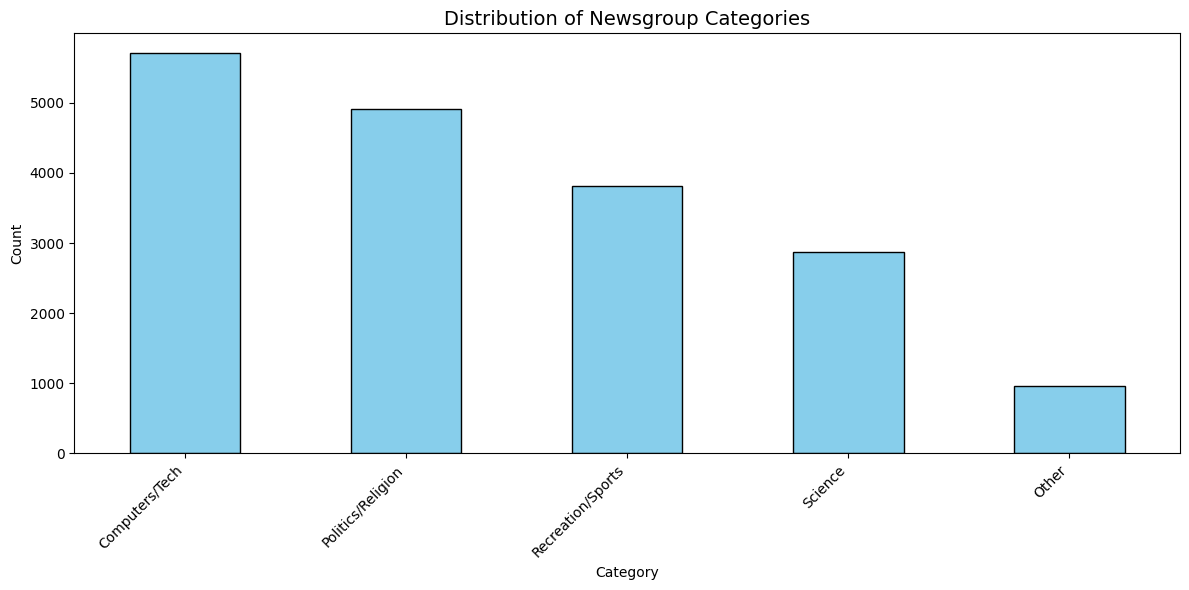

In [25]:
# Class Distribution
category_counts = df['broad_category'].value_counts()
print(f"\nCategory counts:")
print(category_counts)

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Newsgroup Categories', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Most Common Words:
       Word  Frequency
0      like       5853
1    people       5705
2       use       4737
3      time       4595
4      work       3581
5      want       3516
6      give       3475
7        go       3462
8      look       3397
9      need       3315
10     make       3284
11     year       3227
12      get       3213
13      try       3144
14   system       3033
15    thing       2998
16      god       2922
17     call       2863
18  problem       2689
19     file       2600


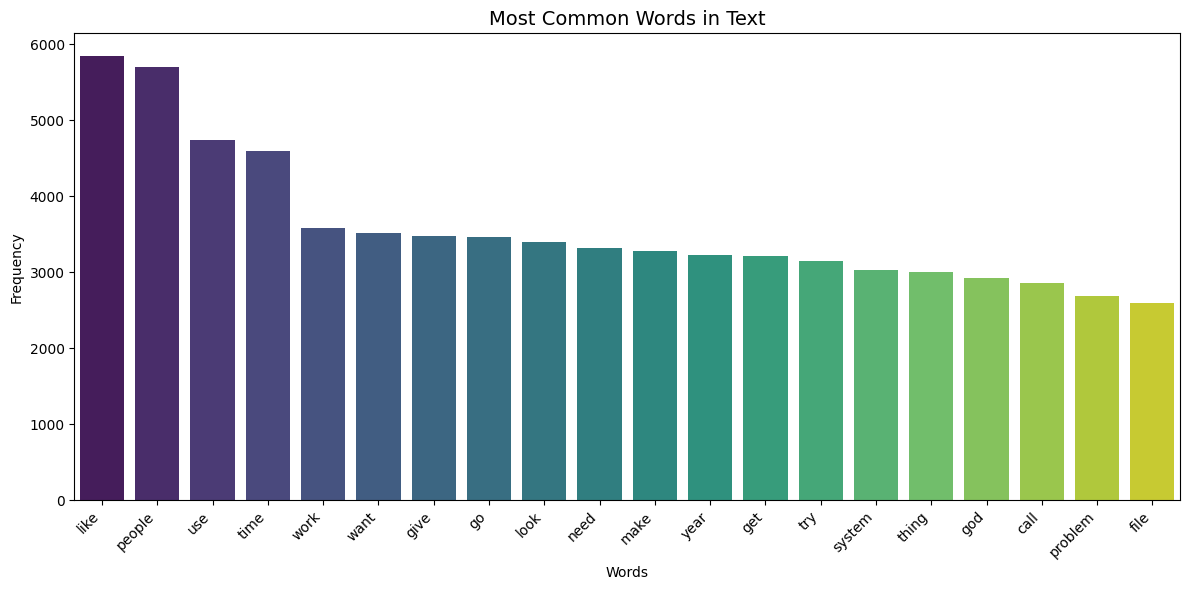

In [26]:
# Most common words
# Get all words from cleaned text
all_text = ' '.join(df['cleaned_text'].dropna())
all_words = all_text.split()
word_freq = Counter(all_words)
top_words_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

print("\nMost Common Words:")
print(top_words_df)

# Plot most common words
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency', palette='viridis')
plt.title('Most Common Words in Text', fontsize=14)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

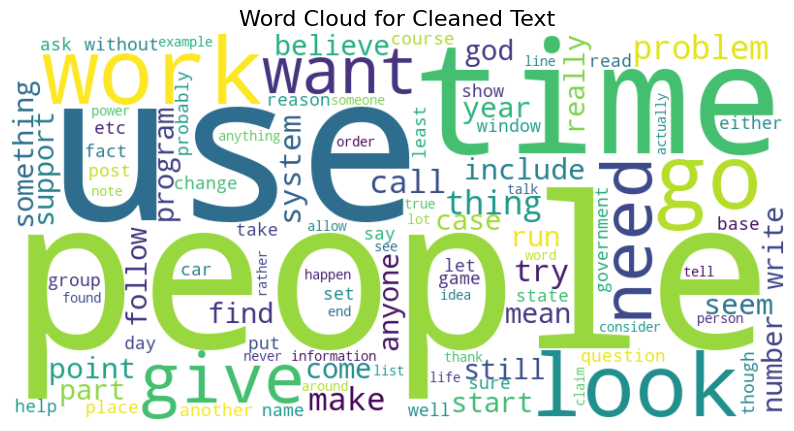

In [27]:
# Overall Word Cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     max_words=100, colormap='viridis').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cleaned Text', fontsize=16)
plt.show()

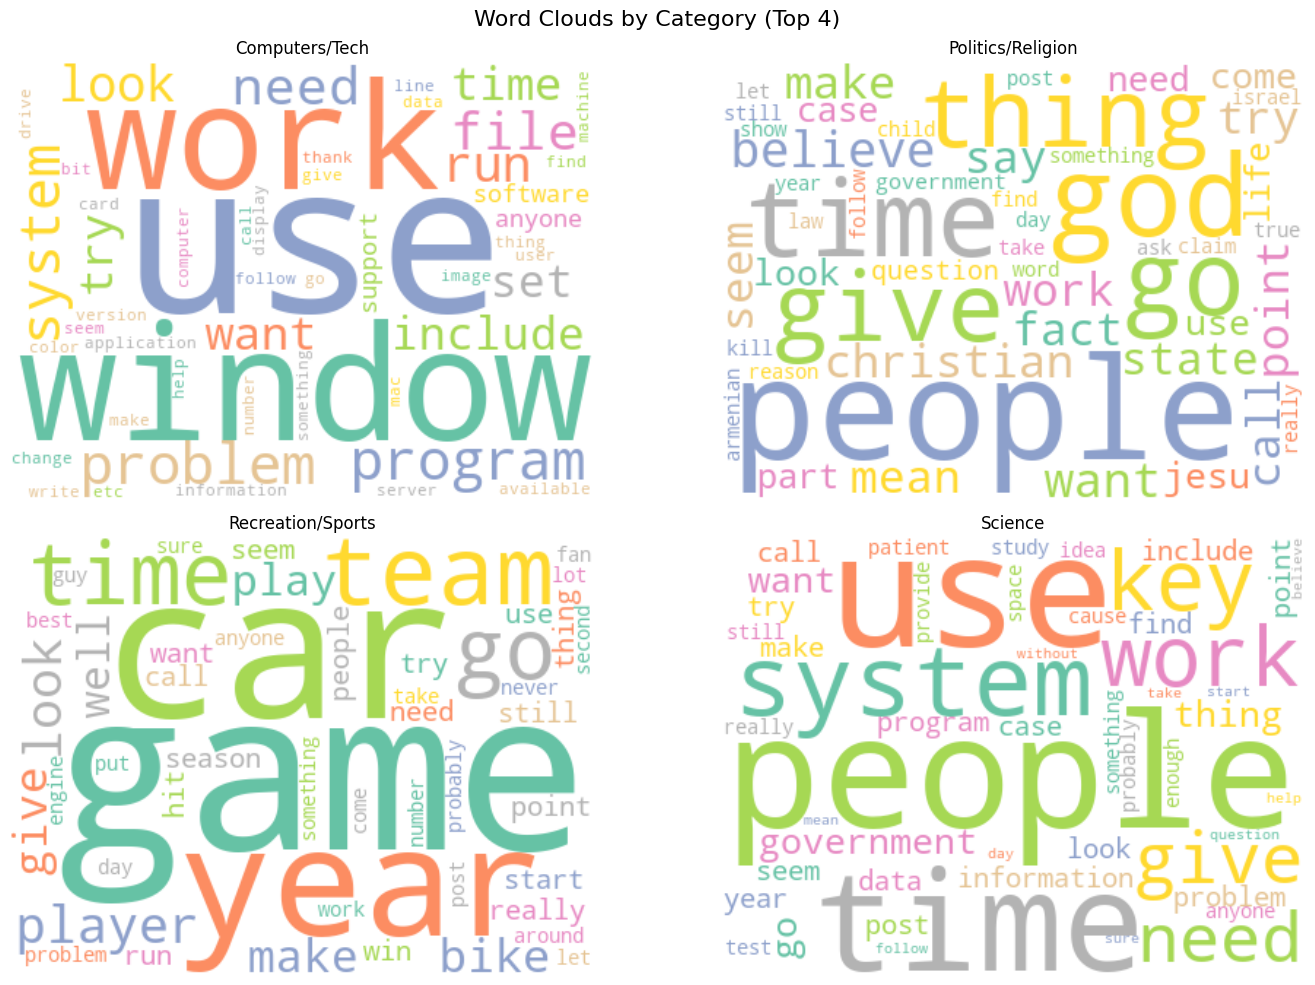

In [28]:
top_4_categories = df['broad_category'].value_counts().head(4).index

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, category in enumerate(top_4_categories):
    cat_text = ' '.join(df[df['broad_category'] == category]['cleaned_text'].dropna())
    
    if len(cat_text) > 0:
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             max_words=50, colormap='Set2').generate(cat_text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'{category}', fontsize=12)

plt.suptitle('Word Clouds by Category (Top 4)', fontsize=16)
plt.tight_layout()
plt.show()

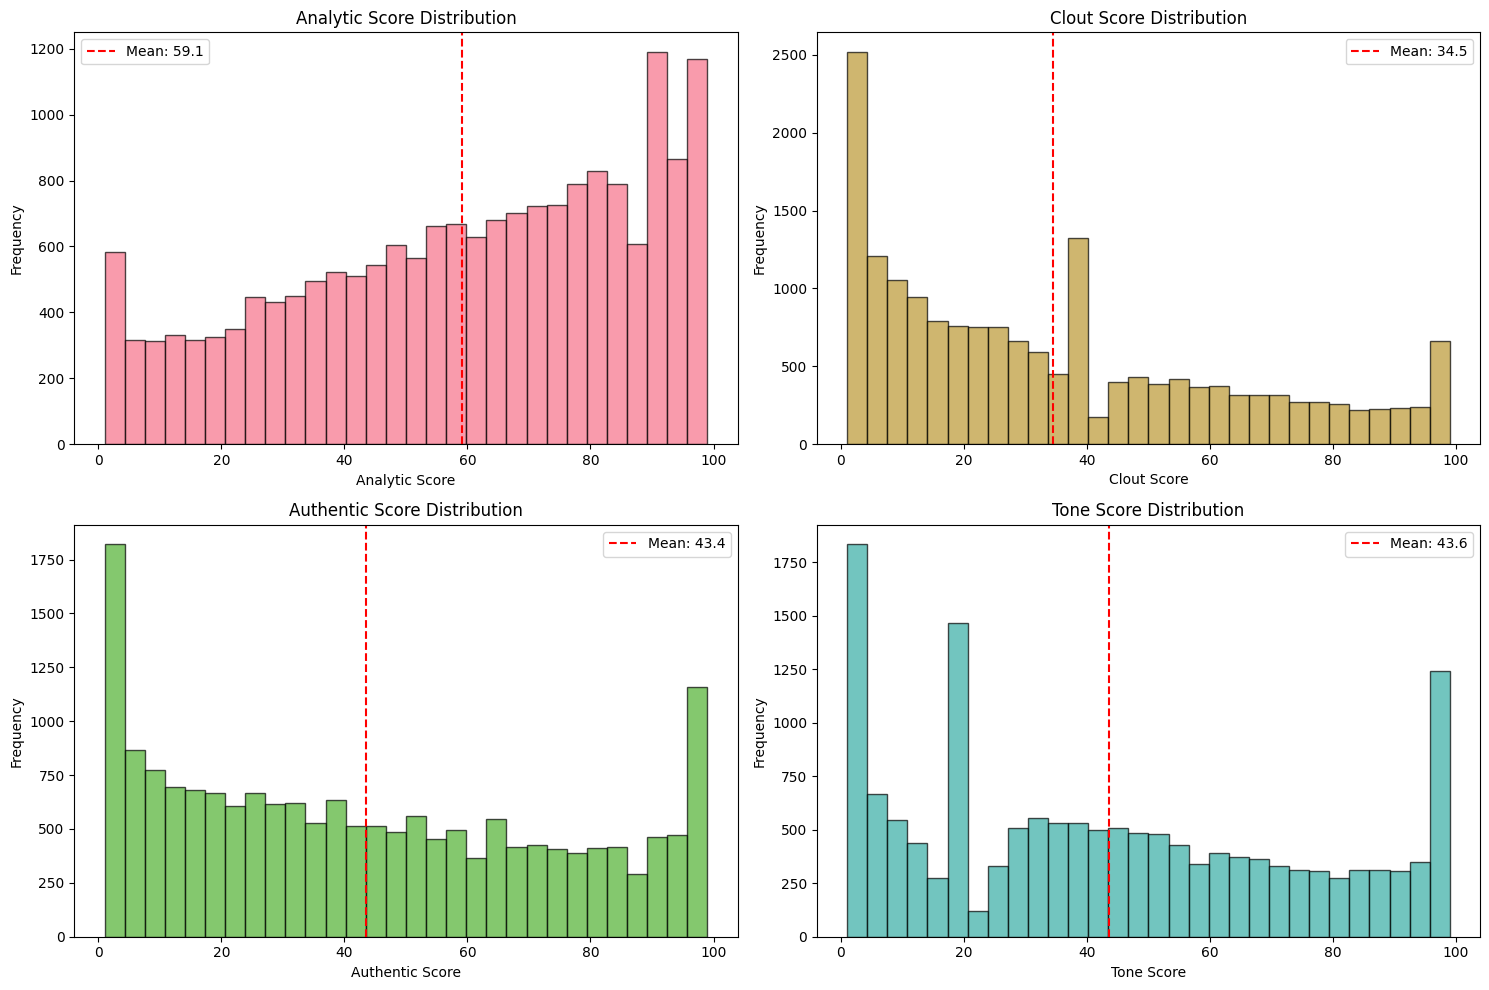

In [29]:
liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']

plt.figure(figsize=(15, 10))

for i, col in enumerate(liwc_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, color=f'C{i-1}', edgecolor='black')
    plt.title(f'{col} Score Distribution')
    plt.xlabel(f'{col} Score')
    plt.ylabel('Frequency')
    plt.axvline(df[col].mean(), color='red', linestyle='--', 
               label=f'Mean: {df[col].mean():.1f}')
    plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Create word_count column first
df['word_count'] = df['cleaned_text'].str.split().str.len()

In [31]:
# Category Summary Table
category_summary = df.groupby('label_name').agg({
    'word_count': ['mean', 'median', 'std'],
    'Analytic': 'mean',
    'Clout': 'mean',
    'Authentic': 'mean',
    'Tone': 'mean'
}).round(2)

category_summary.columns = ['Avg_Words', 'Median_Words', 'Std_Words', 
                           'Avg_Analytic', 'Avg_Clout', 'Avg_Authentic', 'Avg_Tone']
print("\nCategory Summary Statistics:")
print(category_summary.head(10))


Category Summary Statistics:
                          Avg_Words  Median_Words  Std_Words  Avg_Analytic  \
label_name                                                                   
alt.atheism                   85.66          39.0     215.47         43.93   
comp.graphics                 68.65          29.0     233.66         61.29   
comp.os.ms-windows.misc       51.80          30.0      96.89         56.38   
comp.sys.ibm.pc.hardware      53.11          34.0      95.25         59.54   
comp.sys.mac.hardware         50.63          30.0     184.53         60.90   
comp.windows.x               104.52          35.0     396.07         63.53   
misc.forsale                  51.75          31.0      74.65         72.97   
rec.autos                     51.70          32.0     103.95         57.83   
rec.motorcycles               43.62          26.0      81.51         56.20   
rec.sport.baseball            54.95          31.0      75.15         56.01   

                          Avg_Clo

Feature Engineering

TF-IDF Vectorization

In [32]:
print("Creating TF-IDF Features...")

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    min_df=3,        # Ignore terms that appear in fewer than 3 documents
    max_df=0.7,      # Ignore terms that appear in more than 70% of documents
    max_features=5000,  # Limit to top 5000 features
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform the cleaned text
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_feature_names)}")
print(f"First 10 features: {tfidf_feature_names[:10]}")

# Convert to dense array for PCA (use sparse matrix for large datasets)
tfidf_dense = tfidf_matrix.toarray()

Creating TF-IDF Features...
TF-IDF matrix shape: (18246, 5000)
Number of features: 5000
First 10 features: ['aaron' 'ab' 'abandon' 'abc' 'abide' 'ability' 'abolish' 'abortion'
 'abraham' 'absence']


Visualizing outcomes by reducing to 2D

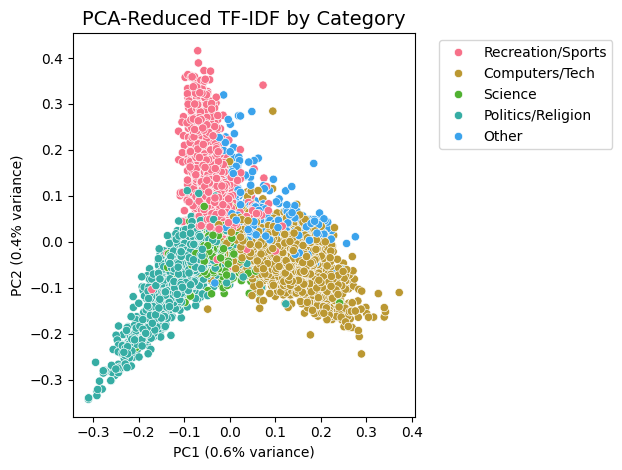

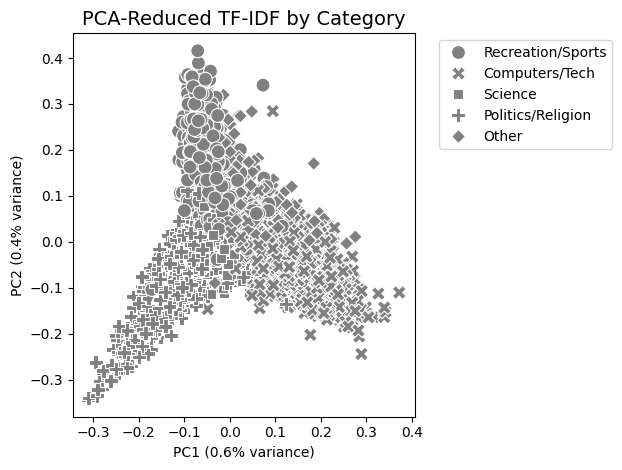

In [53]:
# Reduce matrix to 2D
pca_tfidf = PCA(n_components=2)
tfidf_pca_result = pca_tfidf.fit_transform(tfidf_dense)

# Attach reduced 2D back to original dataframe for future use
df[['tfidf_Dim1','tfidf_Dim2']] = tfidf_pca_result

# Plot with correct column name
sns.scatterplot(df, x='tfidf_Dim1', y='tfidf_Dim2', hue='broad_category')
plt.title('PCA-Reduced TF-IDF by Category', fontsize=14)
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot using different markers instead of colors 
sns.scatterplot(df, x='tfidf_Dim1', y='tfidf_Dim2', style='broad_category', hue='broad_category', 
                palette=['gray']*len(df['broad_category'].unique()), s=100)  
plt.title('PCA-Reduced TF-IDF by Category', fontsize=14)
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1) 
plt.tight_layout()
plt.show()

LIWC

In [34]:
print("\nPreparing LIWC Features...")

liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']

# Check missing values
print("Missing values in LIWC features:")
for col in liwc_cols:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} ({(missing/len(df)*100):.1f}%)")


Preparing LIWC Features...
Missing values in LIWC features:
  Analytic: 111 (0.6%)
  Clout: 544 (3.0%)
  Authentic: 280 (1.5%)
  Tone: 2823 (15.5%)


In [35]:
liwc_features = df[liwc_cols].copy()

# Tone missing = neutral (50)
liwc_features['Tone'] = liwc_features['Tone'].fillna(50) # Technical content lacks emotional tone

# Other features = median
liwc_features = liwc_features.fillna(liwc_features.median()) # Preserves natural data distribution for insufficient text content

LIWC PCA explained variance ratio: [0.35482271 0.25661857]
Total variance explained: 61.1%


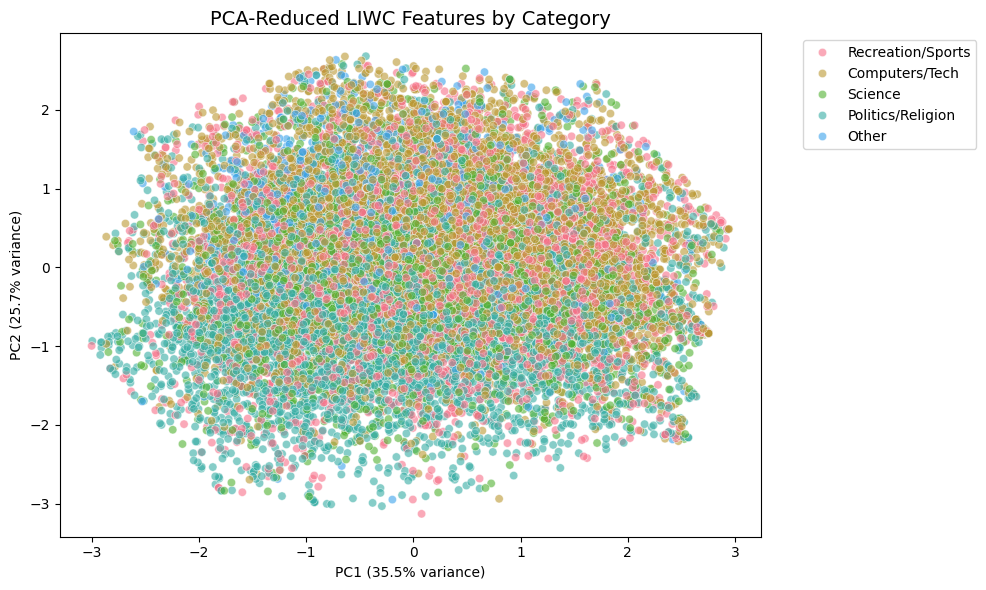

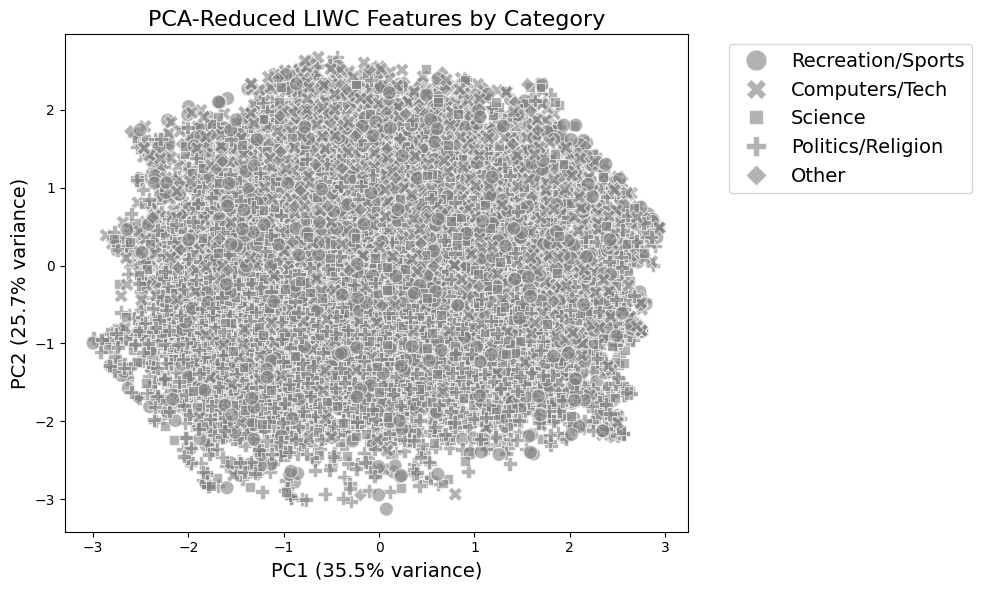

In [61]:
# Standardize LIWC features before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
liwc_scaled = scaler.fit_transform(liwc_features)

# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca_liwc = PCA(n_components=2, random_state=42)
liwc_pca_result = pca_liwc.fit_transform(liwc_scaled)

# Add PCA results back to dataframe
df[['liwc_Dim1', 'liwc_Dim2']] = liwc_pca_result
print(f"LIWC PCA explained variance ratio: {pca_liwc.explained_variance_ratio_}")
print(f"Total variance explained: {pca_liwc.explained_variance_ratio_.sum():.1%}")

# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='liwc_Dim1', y='liwc_Dim2', hue='broad_category', alpha=0.6)
plt.title('PCA-Reduced LIWC Features by Category', fontsize=14)
plt.xlabel(f'PC1 ({pca_liwc.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_liwc.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot using different markers instead of colors 
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='liwc_Dim1', y='liwc_Dim2', style='broad_category', hue='broad_category', 
                palette=['gray']*len(df['broad_category'].unique()), alpha=0.6, s=100) 
plt.title('PCA-Reduced LIWC Features by Category', fontsize=16)
plt.xlabel(f'PC1 ({pca_liwc.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
plt.ylabel(f'PC2 ({pca_liwc.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 14, markerscale=1.5)  
plt.tight_layout()
plt.show()

SBERT

In [37]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [38]:
#SBERT
print("Loading Sentence-BERT model...")

# Load pre-trained Sentence-BERT model
# 'all-MiniLM-L6-v2' is fast, lightweight, and high-quality
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Model loaded successfully!")
print(f"Model max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Prepare texts for SBERT
print("Preparing texts...")
texts_for_sbert = df['cleaned_text_gentle'].fillna('').tolist()
print(f"Total texts to process: {len(texts_for_sbert)}")

# Generate SBERT embeddings
print("Generating Sentence-BERT embeddings...")

sbert_embeddings = model.encode(
    texts_for_sbert,
    show_progress_bar=True,
    batch_size=64,  # Can handle larger batches than BERT
    convert_to_numpy=True,
    normalize_embeddings=False  # Set to True if you want L2 normalized embeddings
)

print(f"SBERT embeddings shape: {sbert_embeddings.shape}")
print(f"Embedding dimension: {sbert_embeddings.shape[1]}")
print("Embeddings generation completed!")


Loading Sentence-BERT model...
Model loaded successfully!
Model max sequence length: 256
Embedding dimension: 384
Preparing texts...
Total texts to process: 18246
Generating Sentence-BERT embeddings...


Batches: 100%|██████████| 286/286 [00:59<00:00,  4.80it/s]

SBERT embeddings shape: (18246, 384)
Embedding dimension: 384
Embeddings generation completed!


Applying PCA for visualization...
SBERT PCA explained variance ratio: [0.04362408 0.02624122]
Total variance explained: 7.0%


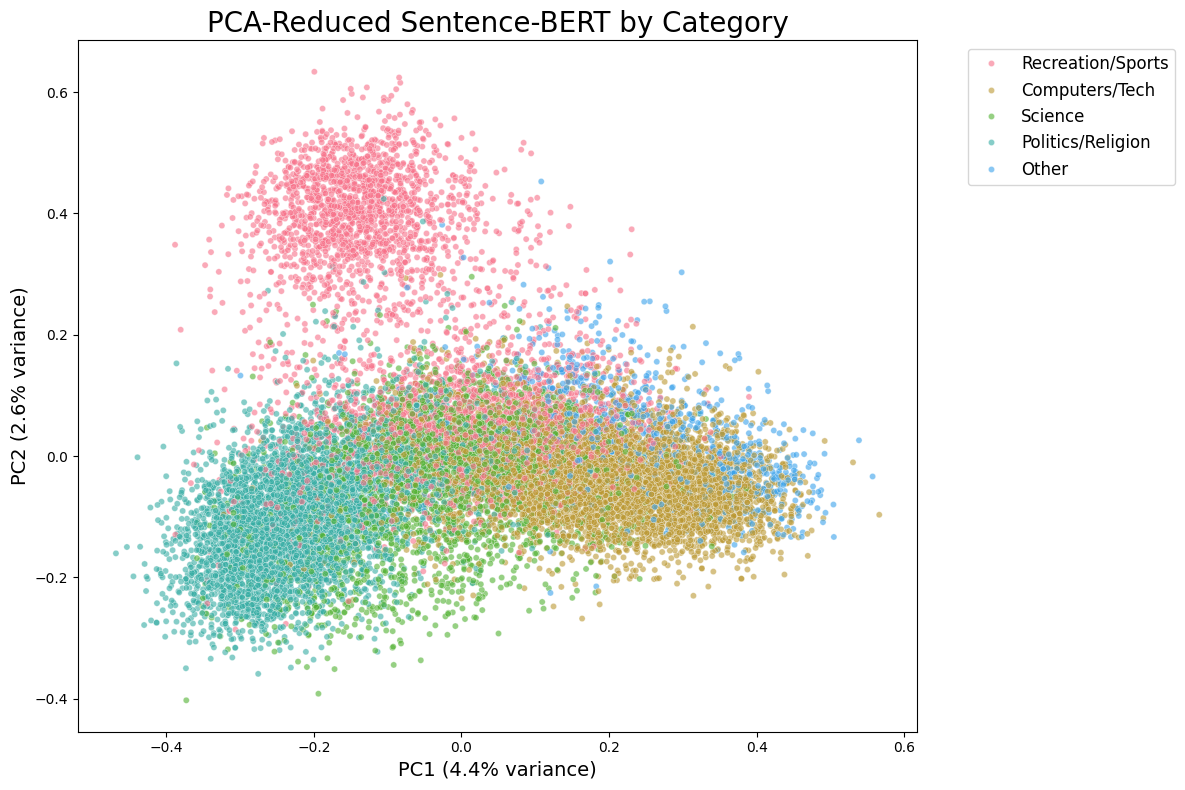

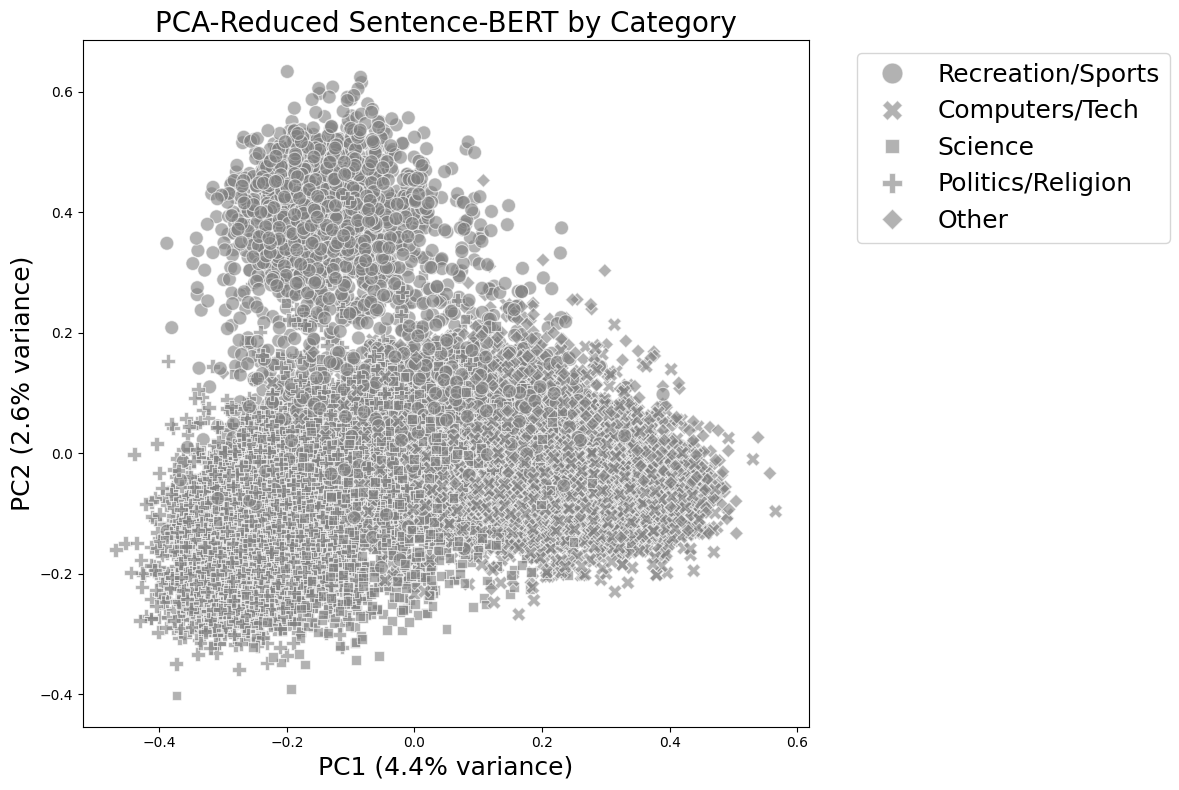

In [62]:
# Apply PCA for visualization
print("Applying PCA for visualization...")
pca_sbert = PCA(n_components=2, random_state=42)
sbert_pca_result = pca_sbert.fit_transform(sbert_embeddings)

# Add PCA results to dataframe
df[['sbert_Dim1', 'sbert_Dim2']] = sbert_pca_result
print(f"SBERT PCA explained variance ratio: {pca_sbert.explained_variance_ratio_}")
print(f"Total variance explained: {pca_sbert.explained_variance_ratio_.sum():.1%}")

# Visualization 1: All categories (will be crowded but shows full picture)
plt.figure(figsize=(12, 8))
sns.scatterplot(df, x='sbert_Dim1', y='sbert_Dim2', hue='broad_category', alpha=0.6, s=20)
plt.title('PCA-Reduced Sentence-BERT by Category', fontsize=20)
plt.xlabel(f'PC1 ({pca_sbert.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)  
plt.ylabel(f'PC2 ({pca_sbert.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Plot using different markers instead of colors
plt.figure(figsize=(12, 8))
sns.scatterplot(df, x='sbert_Dim1', y='sbert_Dim2', style='broad_category', hue='broad_category',
                palette=['gray']*len(df['broad_category'].unique()), alpha=0.6, s=100)
plt.title('PCA-Reduced Sentence-BERT by Category', fontsize=20)
plt.xlabel(f'PC1 ({pca_sbert.explained_variance_ratio_[0]:.1%} variance)', fontsize=18)  
plt.ylabel(f'PC2 ({pca_sbert.explained_variance_ratio_[1]:.1%} variance)', fontsize=18)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, markerscale = 1.5)
plt.tight_layout()
plt.show()

Model Fitting

In [40]:
# Define models
from sklearn.ensemble import VotingClassifier

# Define original models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'LinearSVM': LinearSVC(random_state=42, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=42),
    
    # Add Hard Vote as LinearSVM doesn't support predict_proba in Soft Vote
    'Hard Voting': VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('svm', LinearSVC(random_state=42, max_iter=2000)), 
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='hard'
    )
}
# Prepare target variable (use broad_category for cleaner results)
y = df['broad_category']  # or use 'label_name' for 20-class classification

print(f"Target variable shape: {y.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class distribution:\n{y.value_counts()}")

Target variable shape: (18246,)
Number of classes: 5
Class distribution:
broad_category
Computers/Tech       5704
Politics/Religion    4906
Recreation/Sports    3808
Science              2873
Other                 955
Name: count, dtype: int64


In [44]:
# TF-IDF Features 
X_tfidf = tfidf_dense  # Your TF-IDF matrix
print(f"TF-IDF features shape: {X_tfidf.shape}")

# LIWC Features (standardized)
liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']
X_liwc_raw = liwc_features  # Your processed LIWC features
scaler_liwc = StandardScaler()
X_liwc = scaler_liwc.fit_transform(X_liwc_raw)
print(f"LIWC features shape: {X_liwc.shape}")

# SBERT Features
X_sbert = sbert_embeddings  # Your SBERT embeddings
print(f"SBERT features shape: {X_sbert.shape}")

# Store all feature sets
feature_sets = {
    'TF-IDF': X_tfidf,
    'LIWC': X_liwc,
    'SBERT': X_sbert
}

TF-IDF features shape: (18246, 5000)
LIWC features shape: (18246, 4)
SBERT features shape: (18246, 384)



EVALUATING MODELS WITH TF-IDF FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.684
Precision: 0.682
Recall: 0.684
F1-score: 0.682
CV Score: 0.679 (+/- 0.014)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.72      0.78      0.75      1141
            Other       0.57      0.47      0.51       191
Politics/Religion       0.75      0.72      0.73       981
Recreation/Sports       0.64      0.69      0.67       762
          Science       0.58      0.51      0.55       575

         accuracy                           0.68      3650
        macro avg       0.65      0.63      0.64      3650
     weighted avg       0.68      0.68      0.68      3650



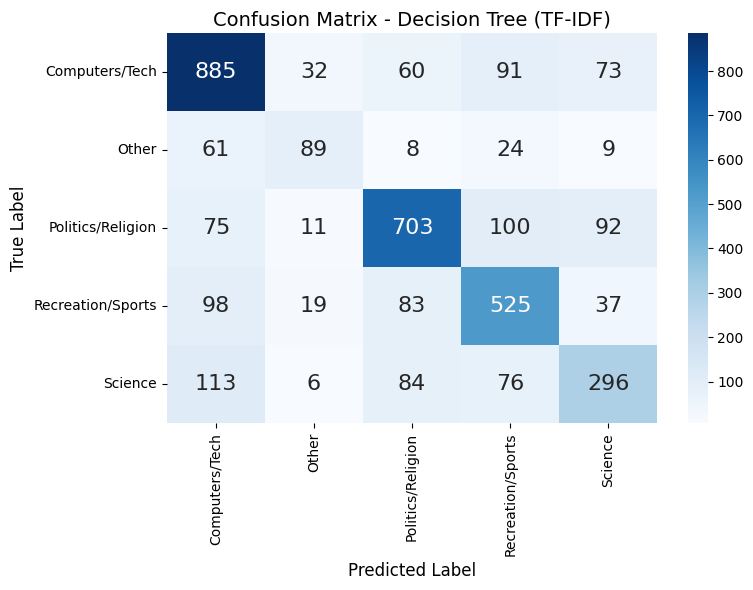


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.853
Precision: 0.855
Recall: 0.853
F1-score: 0.850
CV Score: 0.860 (+/- 0.011)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.83      0.92      0.88      1141
            Other       0.88      0.58      0.70       191
Politics/Religion       0.85      0.92      0.88       981
Recreation/Sports       0.88      0.83      0.86       762
          Science       0.86      0.72      0.78       575

         accuracy                           0.85      3650
        macro avg       0.86      0.79      0.82      3650
     weighted avg       0.85      0.85      0.85      3650



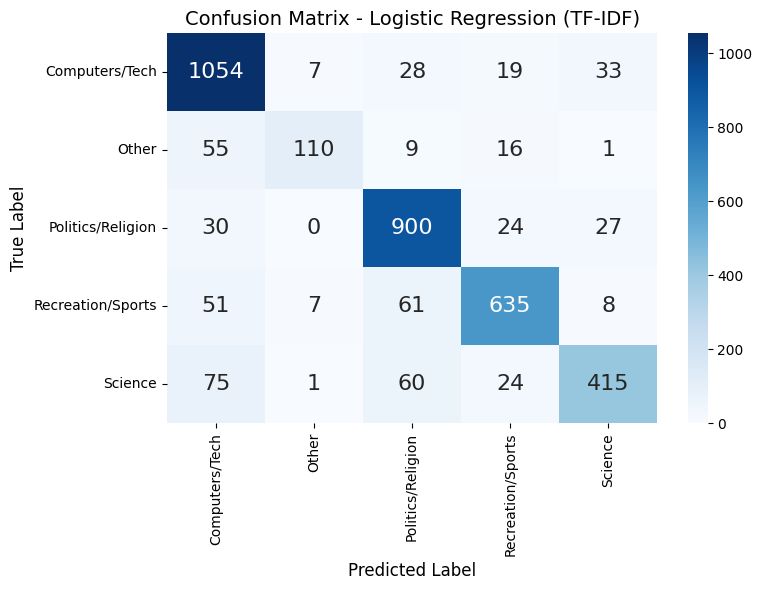


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.854
Precision: 0.853
Recall: 0.854
F1-score: 0.852
CV Score: 0.858 (+/- 0.007)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.84      0.91      0.88      1141
            Other       0.81      0.66      0.73       191
Politics/Religion       0.86      0.90      0.88       981
Recreation/Sports       0.89      0.83      0.86       762
          Science       0.83      0.75      0.78       575

         accuracy                           0.85      3650
        macro avg       0.85      0.81      0.83      3650
     weighted avg       0.85      0.85      0.85      3650



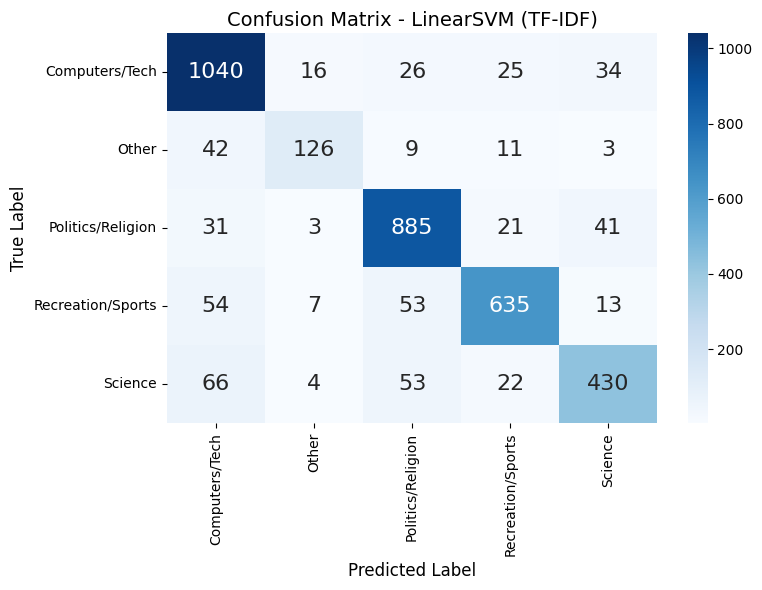


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.804
Precision: 0.812
Recall: 0.804
F1-score: 0.797
CV Score: 0.789 (+/- 0.008)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.77      0.92      0.84      1141
            Other       0.85      0.52      0.65       191
Politics/Religion       0.82      0.87      0.84       981
Recreation/Sports       0.80      0.79      0.79       762
          Science       0.90      0.56      0.69       575

         accuracy                           0.80      3650
        macro avg       0.83      0.73      0.76      3650
     weighted avg       0.81      0.80      0.80      3650



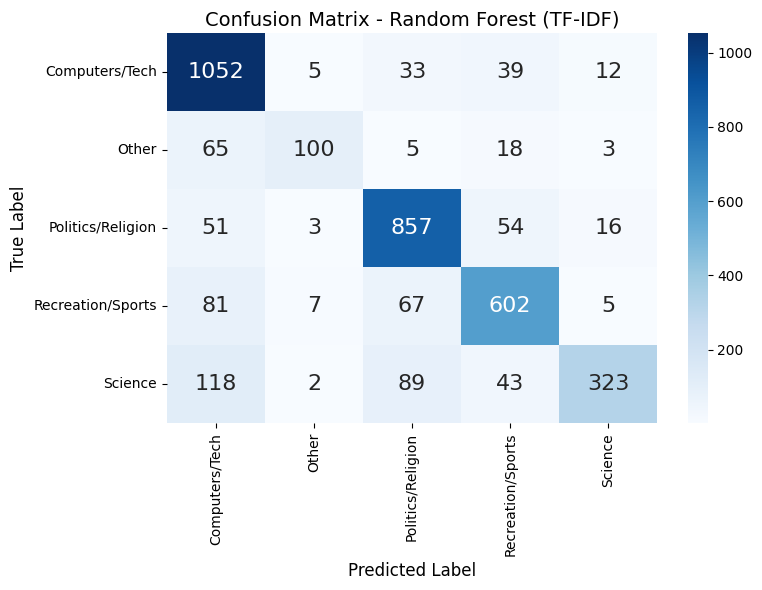


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.833
Precision: 0.842
Recall: 0.833
F1-score: 0.829
CV Score: 0.831 (+/- 0.005)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.78      0.95      0.86      1141
            Other       0.86      0.56      0.68       191
Politics/Religion       0.83      0.91      0.87       981
Recreation/Sports       0.89      0.78      0.83       762
          Science       0.91      0.63      0.75       575

         accuracy                           0.83      3650
        macro avg       0.86      0.77      0.80      3650
     weighted avg       0.84      0.83      0.83      3650



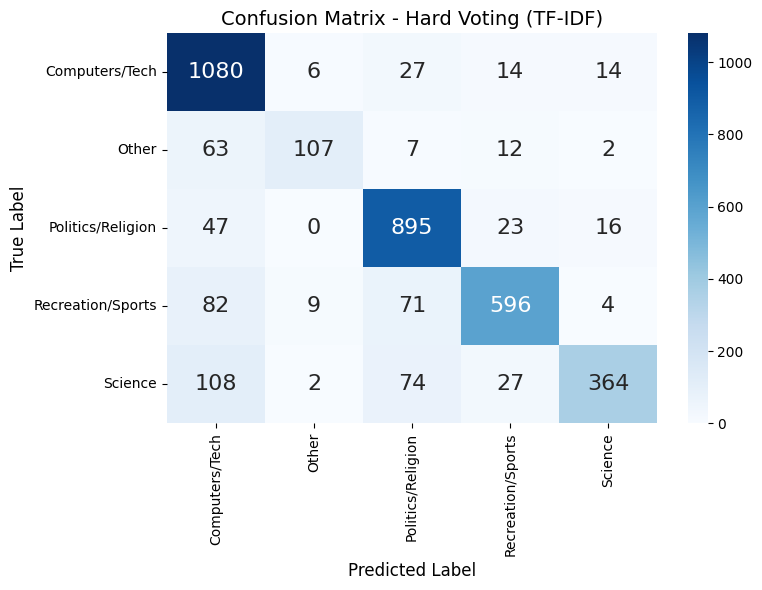

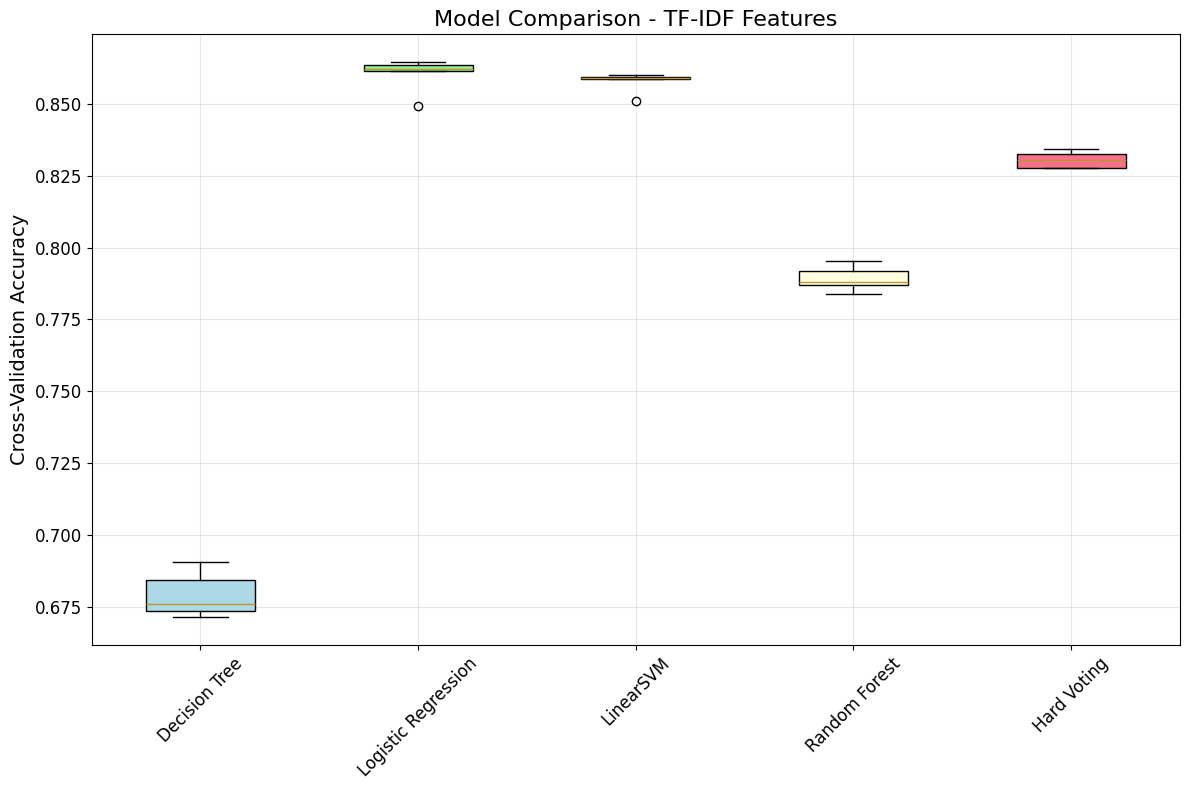


EVALUATING MODELS WITH LIWC FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.327
Precision: 0.327
Recall: 0.327
F1-score: 0.327
CV Score: 0.326 (+/- 0.009)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.43      0.44      0.44      1141
            Other       0.15      0.15      0.15       191
Politics/Religion       0.39      0.39      0.39       981
Recreation/Sports       0.23      0.24      0.23       762
          Science       0.19      0.19      0.19       575

         accuracy                           0.33      3650
        macro avg       0.28      0.28      0.28      3650
     weighted avg       0.33      0.33      0.33      3650



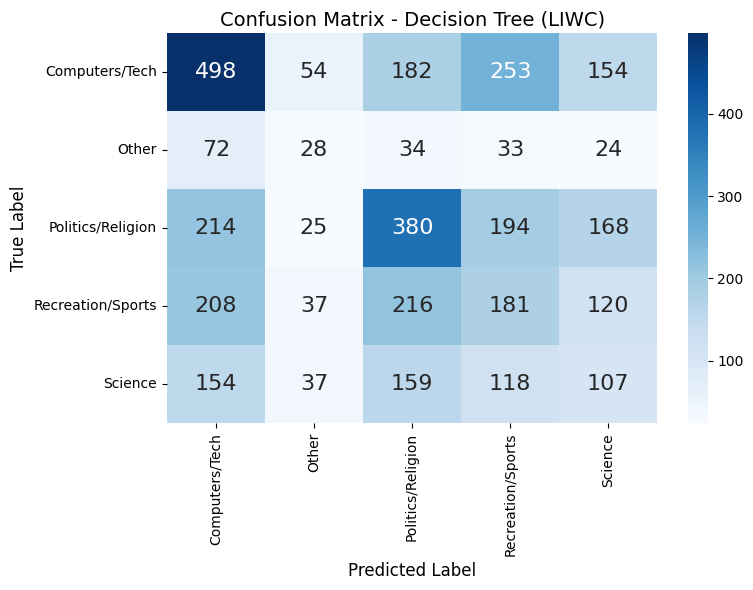


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.435
Precision: 0.340
Recall: 0.435
F1-score: 0.347
CV Score: 0.430 (+/- 0.010)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.43      0.74      0.54      1141
            Other       0.00      0.00      0.00       191
Politics/Religion       0.45      0.68      0.54       981
Recreation/Sports       0.41      0.09      0.15       762
          Science       0.00      0.00      0.00       575

         accuracy                           0.43      3650
        macro avg       0.26      0.30      0.25      3650
     weighted avg       0.34      0.43      0.35      3650



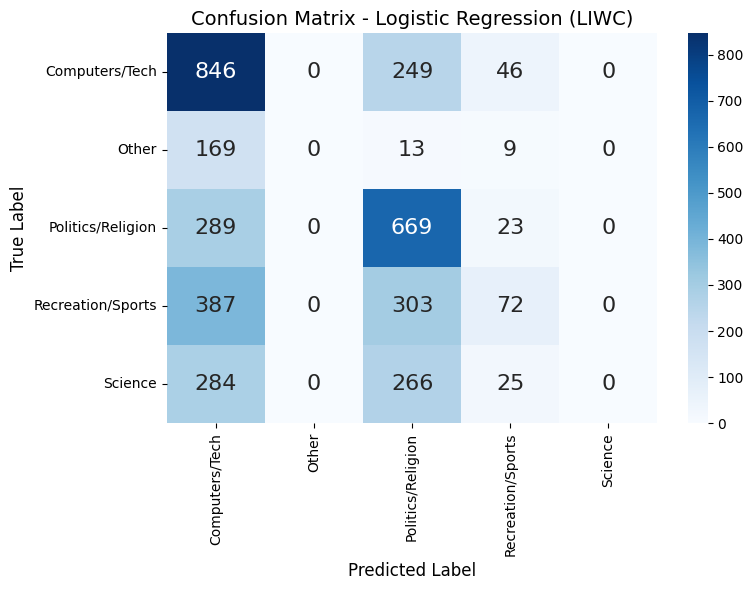


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.430
Precision: 0.354
Recall: 0.430
F1-score: 0.326
CV Score: 0.428 (+/- 0.007)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.43      0.75      0.54      1141
            Other       0.00      0.00      0.00       191
Politics/Religion       0.43      0.70      0.53       981
Recreation/Sports       0.50      0.03      0.06       762
          Science       0.00      0.00      0.00       575

         accuracy                           0.43      3650
        macro avg       0.27      0.30      0.23      3650
     weighted avg       0.35      0.43      0.33      3650



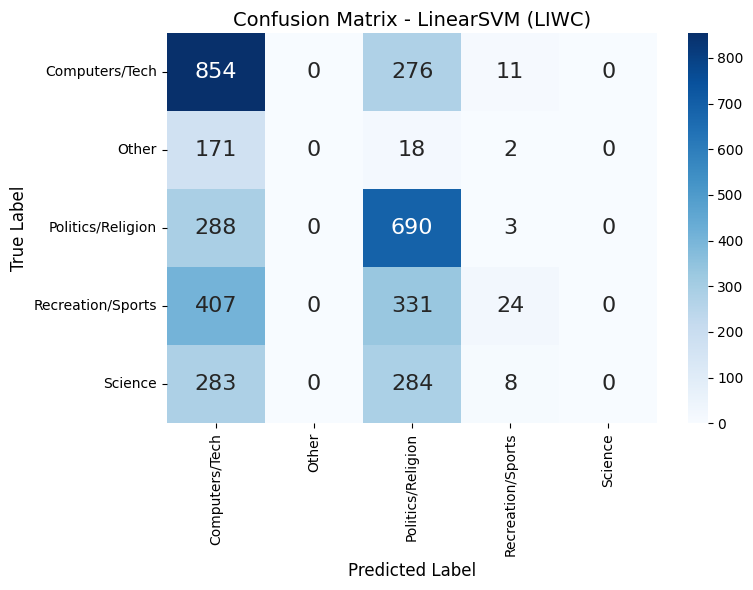


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.406
Precision: 0.373
Recall: 0.406
F1-score: 0.380
CV Score: 0.401 (+/- 0.008)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.46      0.59      0.52      1141
            Other       0.26      0.08      0.12       191
Politics/Religion       0.45      0.56      0.50       981
Recreation/Sports       0.29      0.23      0.25       762
          Science       0.21      0.11      0.15       575

         accuracy                           0.41      3650
        macro avg       0.33      0.31      0.31      3650
     weighted avg       0.37      0.41      0.38      3650



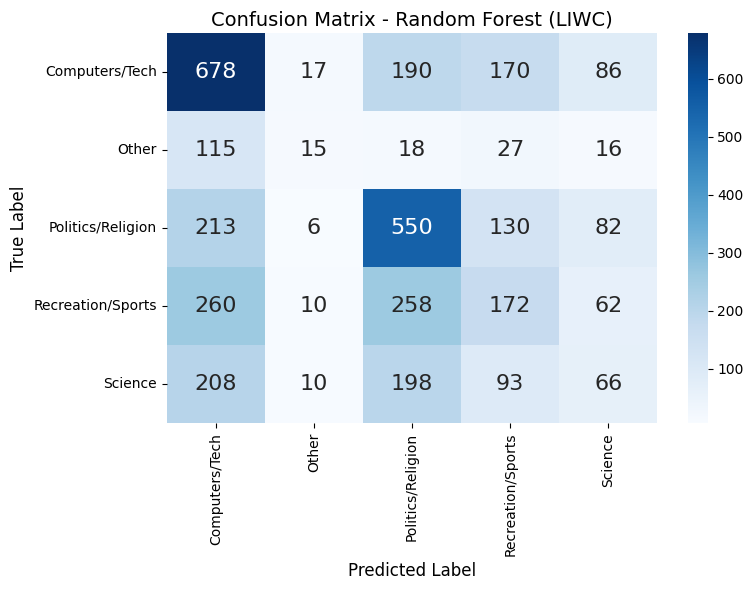


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.427
Precision: 0.361
Recall: 0.427
F1-score: 0.329
CV Score: 0.430 (+/- 0.009)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.42      0.76      0.54      1141
            Other       0.00      0.00      0.00       191
Politics/Religion       0.44      0.66      0.53       981
Recreation/Sports       0.38      0.04      0.08       762
          Science       0.20      0.01      0.01       575

         accuracy                           0.43      3650
        macro avg       0.29      0.30      0.23      3650
     weighted avg       0.36      0.43      0.33      3650



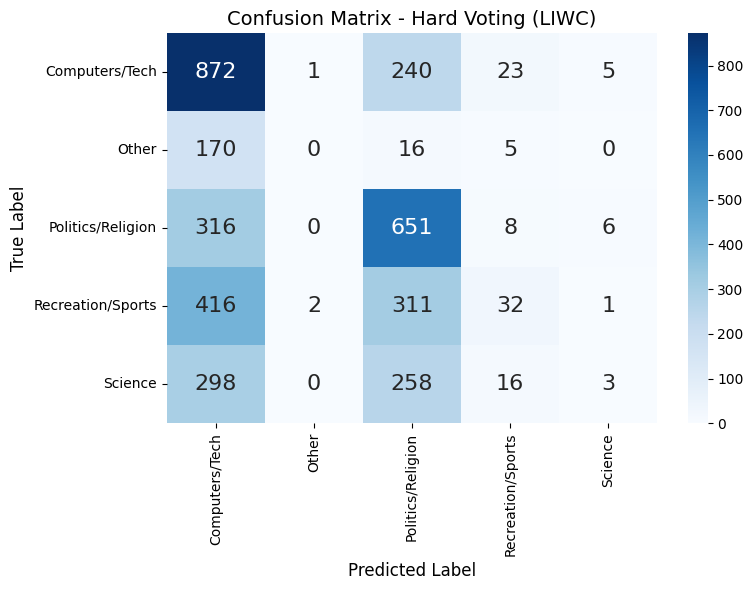

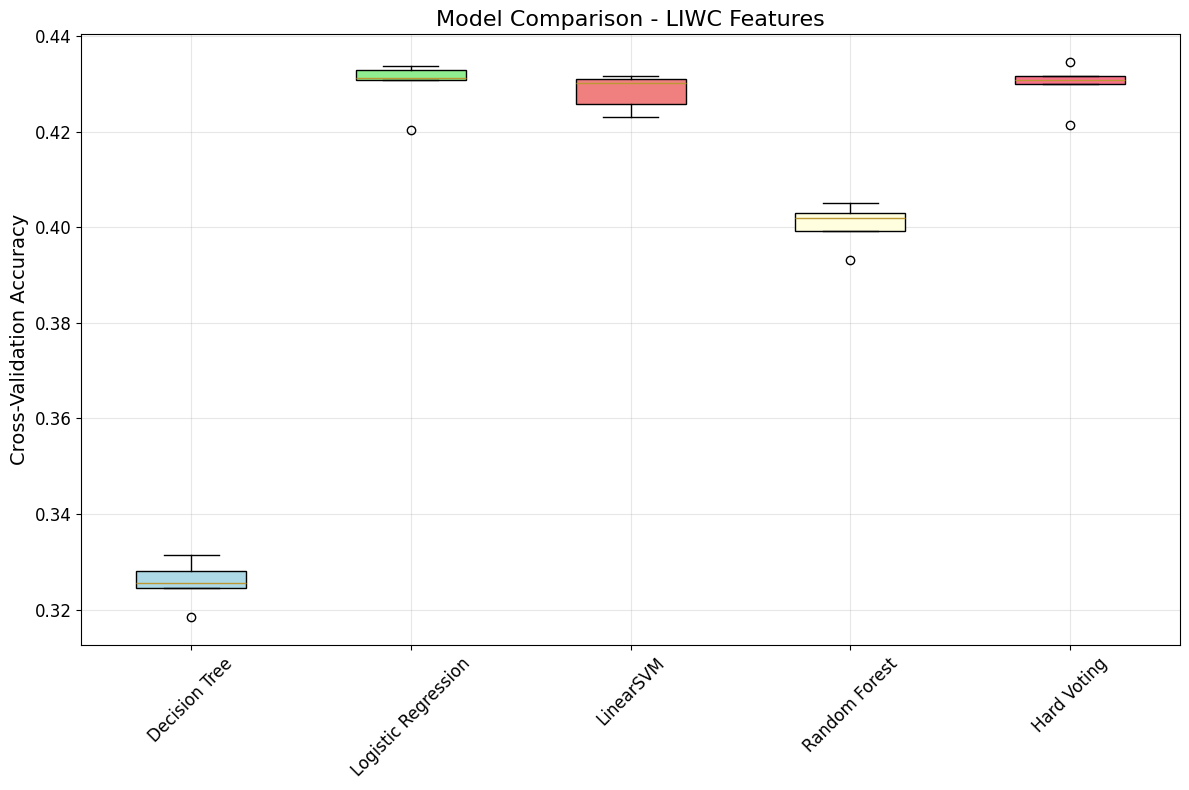


EVALUATING MODELS WITH SBERT FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.587
Precision: 0.590
Recall: 0.587
F1-score: 0.588
CV Score: 0.588 (+/- 0.014)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.67      0.67      0.67      1141
            Other       0.26      0.32      0.29       191
Politics/Religion       0.65      0.67      0.66       981
Recreation/Sports       0.61      0.58      0.59       762
          Science       0.41      0.39      0.40       575

         accuracy                           0.59      3650
        macro avg       0.52      0.53      0.52      3650
     weighted avg       0.59      0.59      0.59      3650



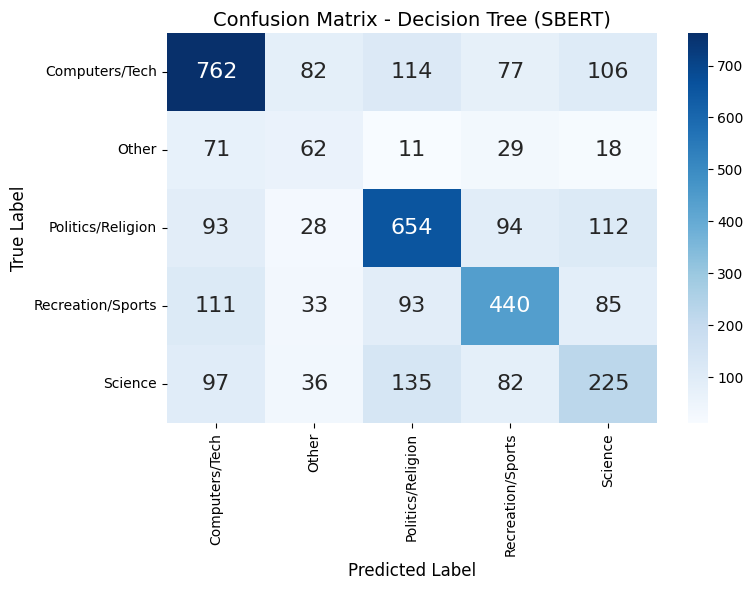


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.881
Precision: 0.880
Recall: 0.881
F1-score: 0.880
CV Score: 0.878 (+/- 0.008)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.89      0.93      0.91      1141
            Other       0.83      0.68      0.75       191
Politics/Religion       0.88      0.93      0.90       981
Recreation/Sports       0.90      0.88      0.89       762
          Science       0.86      0.78      0.82       575

         accuracy                           0.88      3650
        macro avg       0.87      0.84      0.85      3650
     weighted avg       0.88      0.88      0.88      3650



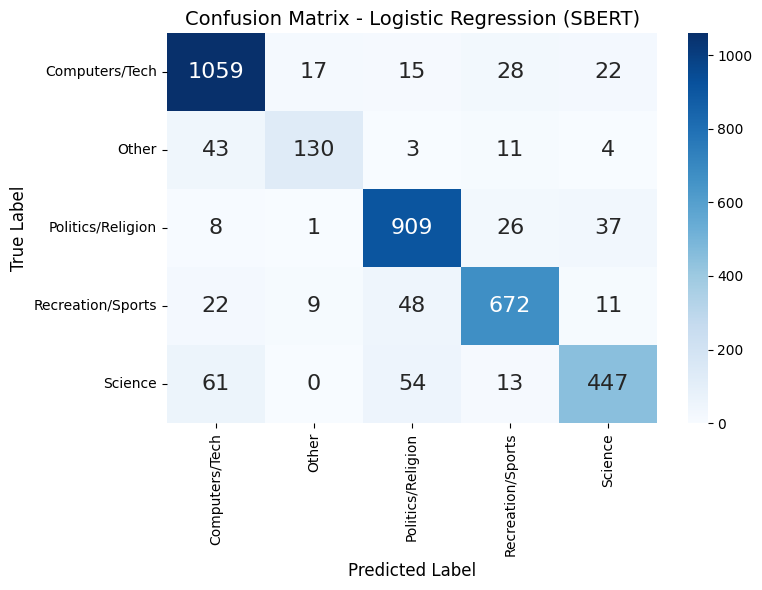


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.879
Precision: 0.878
Recall: 0.879
F1-score: 0.877
CV Score: 0.877 (+/- 0.010)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.89      0.93      0.91      1141
            Other       0.79      0.68      0.73       191
Politics/Religion       0.88      0.92      0.90       981
Recreation/Sports       0.90      0.88      0.89       762
          Science       0.86      0.77      0.81       575

         accuracy                           0.88      3650
        macro avg       0.86      0.84      0.85      3650
     weighted avg       0.88      0.88      0.88      3650



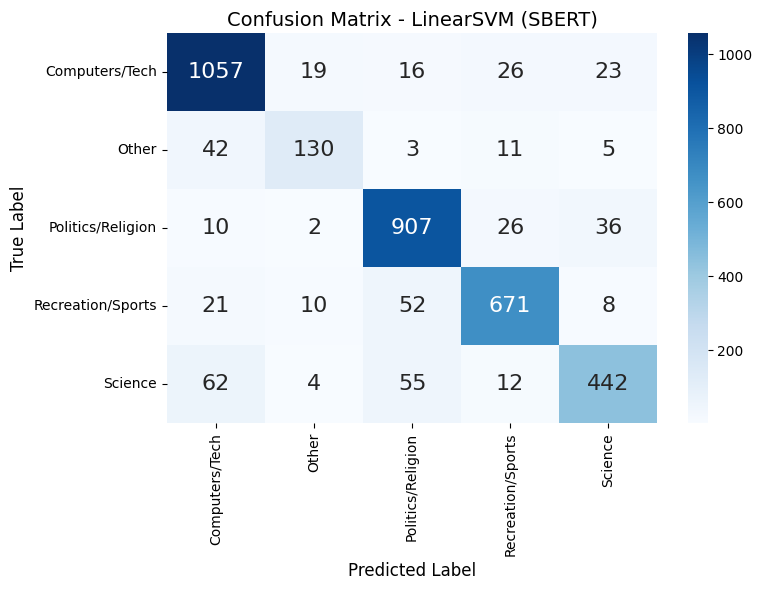


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.825
Precision: 0.836
Recall: 0.825
F1-score: 0.812
CV Score: 0.828 (+/- 0.005)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.78      0.95      0.86      1141
            Other       0.91      0.28      0.43       191
Politics/Religion       0.82      0.94      0.88       981
Recreation/Sports       0.86      0.81      0.84       762
          Science       0.90      0.58      0.70       575

         accuracy                           0.83      3650
        macro avg       0.86      0.71      0.74      3650
     weighted avg       0.84      0.83      0.81      3650



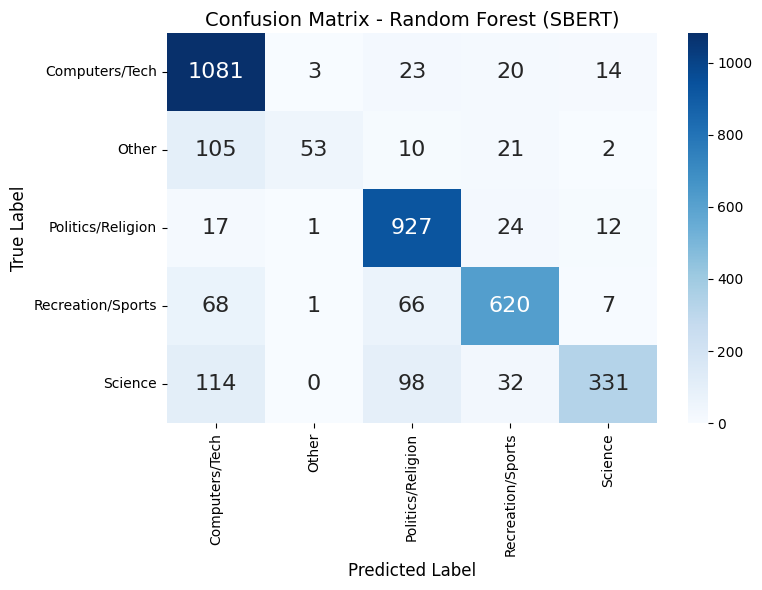


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.864
Precision: 0.865
Recall: 0.864
F1-score: 0.860
CV Score: 0.866 (+/- 0.006)

Classification Report:
                   precision    recall  f1-score   support

   Computers/Tech       0.84      0.94      0.89      1141
            Other       0.83      0.53      0.65       191
Politics/Religion       0.86      0.94      0.90       981
Recreation/Sports       0.91      0.86      0.88       762
          Science       0.87      0.70      0.77       575

         accuracy                           0.86      3650
        macro avg       0.86      0.79      0.82      3650
     weighted avg       0.86      0.86      0.86      3650



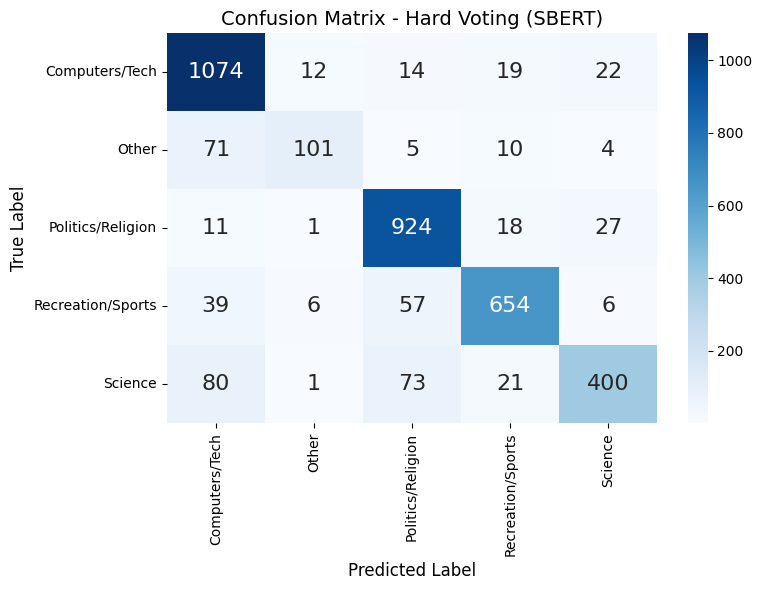

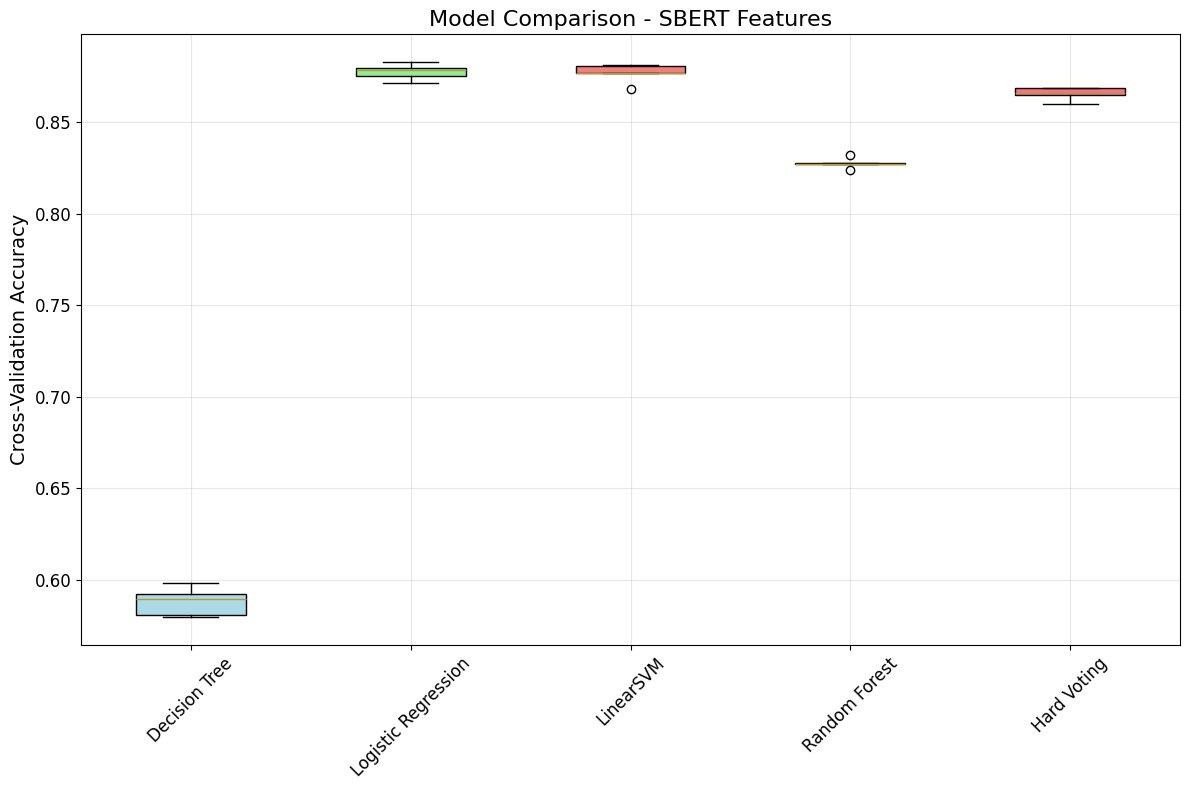

In [ ]:
# Initialize dictionary to store all results
all_results = {}

# Iterate through each feature set
for feature_name, X in feature_sets.items():
    print(f"\n{'=' * 60}")
    print(f"EVALUATING MODELS WITH {feature_name.upper()} FEATURES")
    print(f"{'=' * 60}")
    
    # Split data with stratification for balanced classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Store results for this feature set
    feature_results = {}
    
    # Evaluate each model
    for model_name, model in models.items():
        print(f"\n{model_name} Evaluation:")
        print("-" * 40)
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        
        # Store all metrics
        feature_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'CV_Scores': cv_scores
        }
        
        # Print results
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(y.unique()),
                    yticklabels=sorted(y.unique()),
                    annot_kws={'size': 16})
        plt.title(f'Confusion Matrix - {model_name} ({feature_name})', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Store results for this feature set
    all_results[feature_name] = feature_results
    
    # Model comparison box plot for this feature set
    plt.figure(figsize=(12, 8))
    cv_scores_list = [feature_results[name]['CV_Scores'] for name in models.keys()]
    bp = plt.boxplot(cv_scores_list, labels=models.keys(), patch_artist=True)
    plt.title(f'Model Comparison - {feature_name} Features', fontsize=16)
    plt.ylabel('Cross-Validation Accuracy', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.show()

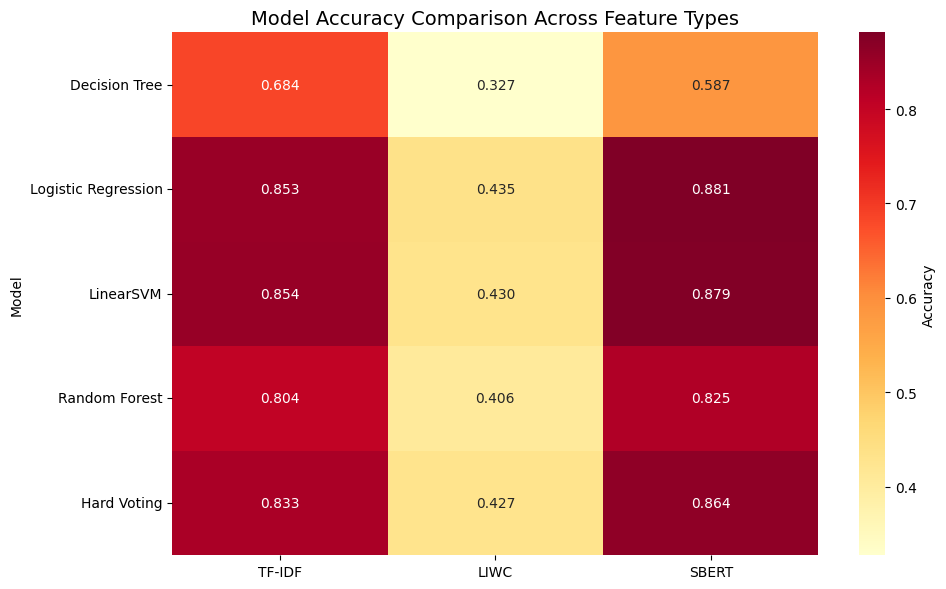

In [ ]:
# Accuracy heatmap
accuracy_data = []
for model_name in models.keys():
    row = {'Model': model_name}
    for feature_name in feature_sets.keys():
        row[feature_name] = all_results[feature_name][model_name]['Accuracy']
    accuracy_data.append(row)

accuracy_df = pd.DataFrame(accuracy_data).set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Accuracy'})
plt.title('Model Accuracy Comparison Across Feature Types', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Print formatted table
print("="*70)
print("MODEL ACCURACY COMPARISON TABLE")
print("="*70)
print(accuracy_df.round(3))

# Print styled table with better formatting
print(f"\n{'='*80}")
print("DETAILED ACCURACY COMPARISON")
print(f"{'='*80}")

# Create a more detailed table with rankings
detailed_table = accuracy_df.round(3).copy()

# Add best model for each feature type (row-wise)
best_per_feature = detailed_table.idxmax(axis=0)
print(f"\nBest model per feature type:")
for feature, best_model in best_per_feature.items():
    best_score = detailed_table.loc[best_model, feature]
    print(f"  {feature:12s}: {best_model:18s} ({best_score:.3f})")

# Add best feature for each model (column-wise)
best_per_model = detailed_table.idxmax(axis=1)
print(f"\nBest feature type per model:")
for model, best_feature in best_per_model.items():
    best_score = detailed_table.loc[model, best_feature]
    print(f"  {model:18s}: {best_feature:12s} ({best_score:.3f})")

# Overall best combination
overall_best = detailed_table.max().max()
best_location = detailed_table.stack().idxmax()
print(f"\nOverall best performance:")
print(f"  {best_location[1]} + {best_location[0]}: {overall_best:.3f}")

MODEL ACCURACY COMPARISON TABLE
                     TF-IDF   LIWC  SBERT
Model                                    
Decision Tree         0.684  0.327  0.587
Logistic Regression   0.853  0.435  0.881
LinearSVM             0.854  0.430  0.879
Random Forest         0.804  0.406  0.825
Hard Voting           0.833  0.427  0.864

DETAILED ACCURACY COMPARISON

Best model per feature type:
  TF-IDF      : LinearSVM          (0.854)
  LIWC        : Logistic Regression (0.435)
  SBERT       : Logistic Regression (0.881)

Best feature type per model:
  Decision Tree     : TF-IDF       (0.684)
  Logistic Regression: SBERT        (0.881)
  LinearSVM         : SBERT        (0.879)
  Random Forest     : SBERT        (0.825)
  Hard Voting       : SBERT        (0.864)

Overall best performance:
  SBERT + Logistic Regression: 0.881
